# Importing the modules

In [1]:
import os
import shutil
import json
from os import listdir
import cv2
import os, glob
import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from skimage.measure import block_reduce
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

import numpy as np
import math
import pandas as pd
from random import seed
from random import randrange

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import seaborn as sb
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[32m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    Blink = '\033[5m'
    Reverse = '\033[7m'
    END = '\033[0m'
    
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Data Preprocessing

## Read Data:

In [2]:
TrainPath = './ModelDatabase/Train'
ValidPath = './ModelDatabase/Valid'
TestPath = './ModelDatabase/Test'

def Read_Data(path):
    img_list = []
    for filename in listdir(path):
        if filename.endswith('.npy'):
            try:
                img_list.append(filename)
                #img = Image.open('./'+filename) # open the image file
                #img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print(color.Red + 'Bad file:', filename)

    Meta_list = []
    for filename in listdir(path):
        if filename.endswith('.json'):
            try:
                Meta_list.append(filename)
                #img = Image.open('./'+filename) # open the image file
                #img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print(color.Red + 'Bad file:', filename)
    
    return img_list, Meta_list

Train_Im_list, Train_Met_list = Read_Data(TrainPath)
Valid_Im_list, Valid_Met_list = Read_Data(ValidPath)
Test_Im_list, Test_Met_list = Read_Data(TestPath)
print(color.BOLD + color.BLUE + 'Done !' + color.END)

Done !


## Load Data

In [3]:
def Load_Data(FolderPath, Im_List, Met_List):
    
    Data = []#pd.DataFrame({'Blue':[], 'Green':[], 'Red':[], 'Redge':[], 'Nir':[], 'Temp':[], 'Exp':[], 'SSC': []})

    def Bands(Name):
        image = Name[:10]
        if "_1" in image:
            band = 'Blue'
        elif "_2" in image:
            band = 'Green'
        elif "_3" in image:
            band = 'Red'
        elif "_4" in image:
            band = 'Redge'
        else:
            band = 'Nir'
        return band


    img_list_exp = []
    for i in Im_List:
        img_list_exp.append(i[0:8]+i[10:])
    unique_exp = list(dict.fromkeys(img_list_exp))

    for i in range(0, len(unique_exp)):

        blue_name = unique_exp[i][0:8]+'_1'+unique_exp[i][8:]
        bluePath = os.path.join(FolderPath, unique_exp[i][0:8]+'_1'+unique_exp[i][8:])
        greenPath = os.path.join(FolderPath, unique_exp[i][0:8]+'_2'+unique_exp[i][8:])
        redPath = os.path.join(FolderPath, unique_exp[i][0:8]+'_3'+unique_exp[i][8:])
        redgePath = os.path.join(FolderPath, unique_exp[i][0:8]+'_5'+unique_exp[i][8:])
        nirPath = os.path.join(FolderPath, unique_exp[i][0:8]+'_4'+unique_exp[i][8:])

        found = pd.Series(Met_List).str.contains(blue_name[:-4], case=False, na=False)
        found_ind = found.index[found == True].tolist()[0]
        Metadata_loc = Met_List[found_ind]
        metaPath = os.path.join(FolderPath, Metadata_loc)
        with open(metaPath) as json_file:
            MetaData = json.load(json_file)

        Obs_EXP = MetaData['Con_Value']
        Obs_SSC = MetaData['SSC_Value']
        Obs_TEMP = MetaData['TEMP_Value']
        Obs_Exp_Iter = unique_exp[i][9:24]
        
        New_Data = pd.DataFrame({})
        def Pooling(path, band):
            Raw = np.load(path)
            mean_pool = block_reduce(Raw, block_size = (80,80), func = np.mean)
            Ave_SSC = mean_pool.flatten()
            Len_SSC = len(Ave_SSC)

            return Len_SSC, Ave_SSC

        Len_SSC, Observed_blue = Pooling(bluePath, 'Blue') 
        Len_SSC, Observed_green = Pooling(greenPath, 'Green')
        Len_SSC, Observed_red = Pooling(redPath, 'Red') 
        Len_SSC, Observed_redge = Pooling(redgePath, 'Redge')
        Len_SSC, Observed_nir = Pooling(nirPath, 'Nir')
        New_Data['Blue'] = Observed_blue
        New_Data['Green'] = Observed_green
        New_Data['Red'] = Observed_red
        New_Data['Redge'] = Observed_redge
        New_Data['Nir'] = Observed_nir
        New_Data['SSC'] = np.repeat(Obs_SSC, Len_SSC)
        New_Data['Temp'] = np.repeat(Obs_TEMP, Len_SSC)
        New_Data['Exp'] = np.repeat(Obs_EXP, Len_SSC)
        New_Data['Exp_Iter'] = np.repeat(Obs_Exp_Iter, Len_SSC)
        #newData = pd.DataFrame(Obs_SSC, columns=band)
        Data.append(New_Data)
        #Data = pd.concat([Data, New_Data], axis=0, ignore_index=True, join = 'inner')
    Data = pd.concat(Data, axis=0, ignore_index=True, join = 'inner')
    print(color.BOLD + color.BLUE + FolderPath[16:] + ' Ready!' + color.END)
    
    return Data

Train_Data = Load_Data(TrainPath, Train_Im_list, Train_Met_list)
Valid_Data = Load_Data(ValidPath, Valid_Im_list, Valid_Met_list)
Test_Data  = Load_Data(TestPath, Test_Im_list, Test_Met_list)

Train Ready!
Valid Ready!
Test Ready!


## Stats

### seccond method to split

In [21]:
Train_Valid = pd.concat([Train_Data, Valid_Data])
inputs = Train_Valid.copy()
inputs.drop(['SSC', 'Temp', 'Exp', 'Exp_Iter'],axis = 1 , inplace = True)
inputs= inputs.values.tolist()
targets = Train_Valid.copy()
targets = targets.SSC.tolist()
#targets


In [22]:
Train_Data.head()

,Blue,Green,Red,Redge,Nir,SSC,Temp,Exp,Exp_Iter
0,0.049006,0.063901,0.058663,0.039747,0.015381,327.937875,64.5,10_180g_Clay_2021_24_05,1_Forward_10_18
1,0.053875,0.068805,0.063535,0.042557,0.017758,327.937875,64.5,10_180g_Clay_2021_24_05,1_Forward_10_18
2,0.060301,0.073612,0.068871,0.047324,0.019706,327.937875,64.5,10_180g_Clay_2021_24_05,1_Forward_10_18
3,0.064790,0.080350,0.073851,0.050390,0.020997,327.937875,64.5,10_180g_Clay_2021_24_05,1_Forward_10_18
4,0.069004,0.085702,0.078428,0.053268,0.021784,327.937875,64.5,10_180g_Clay_2021_24_05,1_Forward_10_18


In [38]:
fold = 4
it = 1500
Ti=Kfold_T_inputs[fold][it]
print(Ti)
Tt=Kfold_T_targets[fold][it]
print(Tt)
exp = Train_Data.loc[Train_Data['Blue'] == Ti[0]]
print(exp.head())
over = False
for i in range(len(Kfold_V_inputs[fold])):
    if Kfold_V_inputs[fold][i][0] == Ti[0]:
        over = True
        print(Kfold_V_inputs[fold][i])
if over:
    print('overlap!')

[0.05214690283488409, 0.06605652222762227, 0.0628882926557855, 0.0437711148120133, 0.01783085420201456]
473.6880412626009
         Blue     Green       Red     Redge       Nir         SSC  Temp  \
300  0.052147  0.066057  0.062888  0.043771  0.017831  473.688041  64.7   

                         Exp         Exp_Iter  
300  14_260g_Clay_2021_24_05  1_Forward_14_26  


In [25]:
def cross_validation_split(dataset, folds=10):
    V_input_split = list()
    V_target_split = list()
    T_input_split = list()
    T_target_split = list()
    
    Exp_unique = Train_Valid.Exp_Iter.unique()
    Exp_unique_copy = list(Exp_unique.copy())
    #print('Exp_unique_copy')
    #print(Exp_unique_copy)
    fold_size = int(len(Exp_unique_copy) / folds)
    
    for i in range(folds):
        print(color.BOLD + color.YELLOW + 'Fold '+ str(i+1) + color.END) 
        fold_V_Input = list()
        fold_V_Target = list()
        fold_T_Input = list()
        fold_T_Target = list()
        index_storage = []
        
        while len(fold_V_Input) < fold_size:
            index = randrange(len(Exp_unique_copy))
            index_exp_name = Exp_unique_copy.pop(index)
            index_storage.append(index_exp_name)
            EXP_valid_df = dataset.loc[dataset['Exp_Iter'] == index_exp_name]
            
            EXP_valid_input = EXP_valid_df.copy()
            EXP_valid_input.drop(['SSC', 'Temp', 'Exp', 'Exp_Iter'], axis = 1, inplace = True)
            
            EXP_valid_target = EXP_valid_df.copy()
            EXP_valid_target = EXP_valid_target.SSC
            
            fold_V_Input.append(EXP_valid_input.values.tolist())
            fold_V_Target.append(EXP_valid_target.tolist())

        
        V_input_split.append(fold_V_Input)
        V_target_split.append(fold_V_Target)
        
        remaining_images = list(filter(lambda j: j not in index_storage, Exp_unique))
        
        for image in range(len(remaining_images)):
            EXP_train_df = dataset.loc[dataset['Exp_Iter'] == remaining_images[image]]
            EXP_train_input = EXP_train_df.copy()
            EXP_train_input.drop(['SSC', 'Temp', 'Exp', 'Exp_Iter'], axis = 1, inplace = True)
            
            EXP_train_target = EXP_train_df.copy()
            EXP_train_target = EXP_train_target.SSC
            
            fold_T_Input.append(EXP_train_input.values.tolist())
            fold_T_Target.append(EXP_train_target.tolist())
            
        T_input_split.append(fold_T_Input)
        T_target_split.append(fold_T_Target)
        
    return V_input_split, V_target_split, T_input_split, T_target_split

seed(1)
#dataset = [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
input_V_folds, target_V_folds, input_T_folds, target_T_folds = cross_validation_split(Train_Valid, 10)
#print(len(input_folds[0][0][0]))
#print(input_folds[0][0][0])
#flat_target_folds = [item for sublist in target_folds[0] for item in sublist]
#flat_input_folds = [item for sublist in input_folds[0] for item in sublist]
#print(len(flat_target_folds))
#print(len(flat_input_folds))


Kfold_V_inputs = []
Kfold_V_targets = []
Kfold_T_inputs = []
Kfold_T_targets = []

for fold in range(len(target_V_folds)):
    
    V_flat_target_folds = [item for sublist in target_V_folds[fold] for item in sublist]
    V_flat_input_folds = [item for sublist in input_V_folds[fold] for item in sublist]
    T_flat_target_folds = [item for sublist in target_T_folds[fold] for item in sublist]
    T_flat_input_folds = [item for sublist in input_T_folds[fold] for item in sublist]
    
    Kfold_T_inputs.append(T_flat_input_folds)
    Kfold_T_targets.append(T_flat_target_folds)
    Kfold_V_inputs.append(V_flat_input_folds)
    Kfold_V_targets.append(V_flat_target_folds)
    
#check if they add up
cond = len(targets) == len(Kfold_V_targets[0])+len(Kfold_T_targets[0])
if cond:
    print(color.BOLD + color.BLUE + 'Kfold success!' + color.END)
else:
    print(color.BOLD + color.RED + ' Kfold failed!' + color.END)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Kfold success!


### First method

In [4]:
target_train = Train_Data.SSC
Train_Data.drop(['SSC', 'Temp', 'Exp', 'Exp_Iter'],axis = 1 , inplace = True)
target_valid = Valid_Data.SSC
Valid_Data.drop(['SSC', 'Temp', 'Exp', 'Exp_Iter'],axis = 1 , inplace = True)
# Merge inputs and targets
inputs = np.concatenate((Train_Data, Valid_Data), axis=0)
targets = np.concatenate((target_train, target_valid), axis=0)

In [5]:
Train_Data.head()

,Blue,Green,Red,Redge,Nir
0,0.049006,0.063901,0.058663,0.039747,0.015381
1,0.053875,0.068805,0.063535,0.042557,0.017758
2,0.060301,0.073612,0.068871,0.047324,0.019706
3,0.064790,0.080350,0.073851,0.050390,0.020997
4,0.069004,0.085702,0.078428,0.053268,0.021784


In [6]:
test_target = Test_Data.SSC
Test_Data.drop(['SSC', 'Temp', 'Exp', 'Exp_Iter'],axis = 1 , inplace = True)
Test_Data.describe()

,Blue,Green,Red,Redge,Nir
count,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000
mean,0.066708,0.091903,0.087630,0.064461,0.030001
std,0.038101,0.053530,0.058043,0.050776,0.031173
min,0.010762,0.014958,0.018653,0.013589,0.005576
25%,0.035349,0.049727,0.045201,0.028623,0.009672
50%,0.058500,0.077906,0.065726,0.040515,0.014737
75%,0.095625,0.132935,0.117903,0.083342,0.035964
max,0.169746,0.249851,0.281878,0.237879,0.143727


In [13]:
Test_Data.drop(['Exp_Iter'],axis = 1 , inplace = True)#target = Train_Data.SSC
#Train_Data.drop(['SSC', 'Temp', 'Exp'],axis = 1 , inplace = True)
#inputs.describe()
Test_Data.head()

,Blue,Green,Red,Redge,Nir
0,0.055742,0.072977,0.078124,0.060246,0.028884
1,0.063805,0.082387,0.087016,0.066887,0.032757
2,0.072278,0.091998,0.095964,0.073816,0.036636
3,0.081176,0.101529,0.104886,0.080815,0.040123
4,0.089050,0.112190,0.113996,0.087581,0.044400


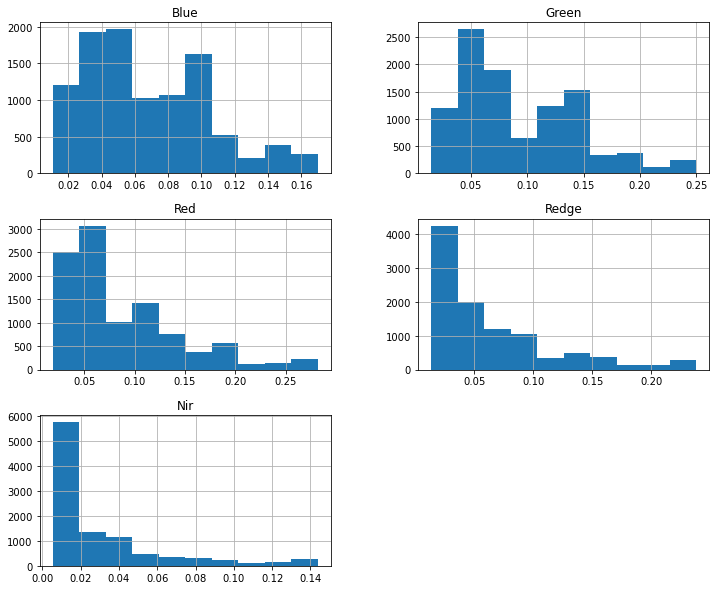

In [7]:
Test_Data.hist(figsize = (12,10))
plt.show()

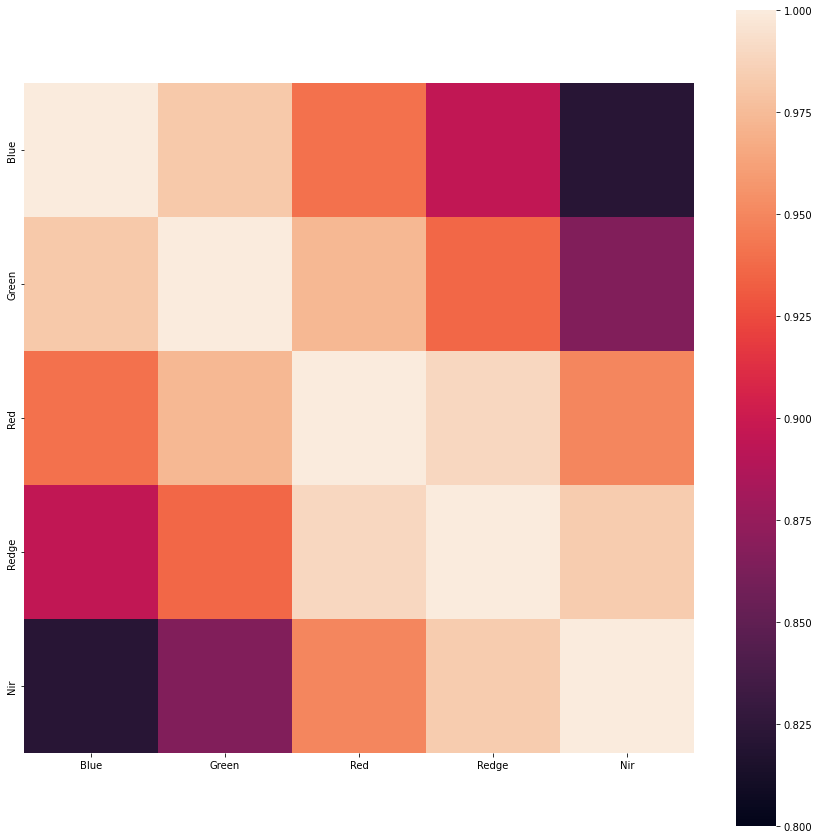

In [10]:
C_mat = Train_Data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmin = .80, square = True)
plt.show()

# Model

## DNN

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/15
1193/1193 - 5s - loss: 1901536.0000 - mean_squared_error: 1901536.0000 - val_loss: 971871.0000 - val_mean_squared_error: 971871.0000
Epoch 2/15
1193/1193 - 4s - loss: 922522.1250 - mean_squared_error: 922522.1250 - val_loss: 2385084.5000 - val_mean_squared_error: 2385084.5000
Epoch 3/15
1193/1193 - 4s - loss: 693814.5000 - mean_squared_error: 693814.5000 - val_loss: 4752663.5000 - val_mean_squared_error: 4752663.5000
Epoch 4/15
1193/1193 - 4s - loss: 620147.9375 - mean_squared_error: 620147.9375 - val_loss: 4978787.0000 - val_mean_squared_error: 4978787.0000
Epoch 5/15
1193/1193 - 4s - loss: 564444.0625 - mean_squared_error: 564444.0625 - val_loss: 4766174.0000 - val_mean_squared_error: 4766174.0000
Epoch 6/15
1193/1193 - 4s - loss: 510430.4688 - mean_squared_error: 510430.4688 - val_loss: 4376817.0000 - val_mean_squared_error: 4376

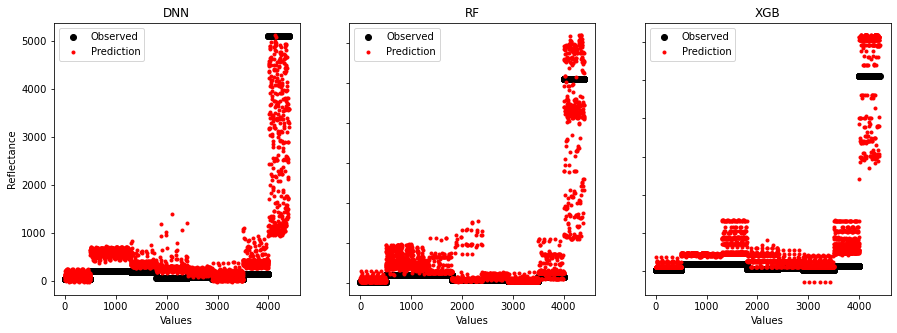

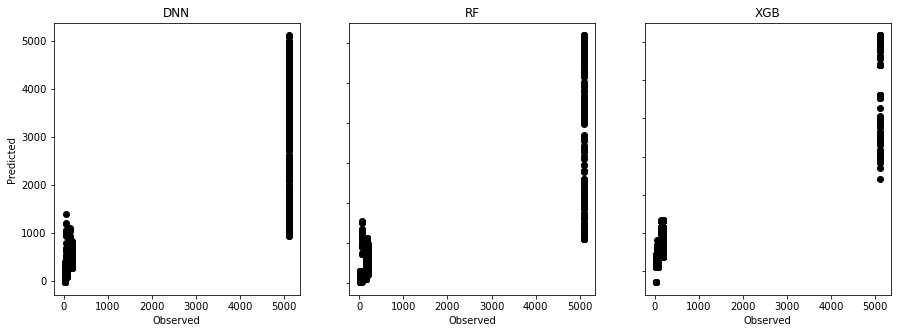

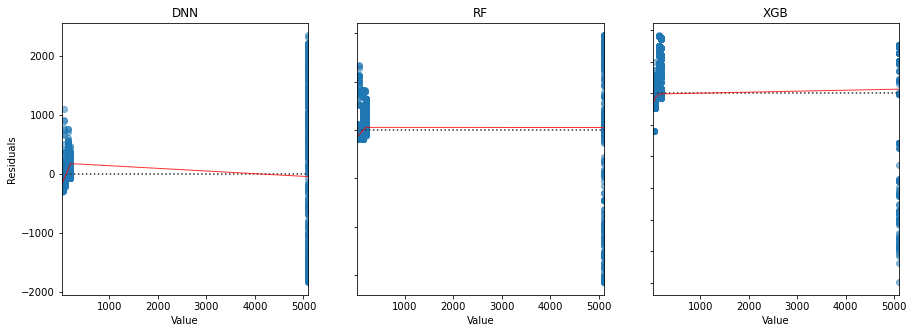

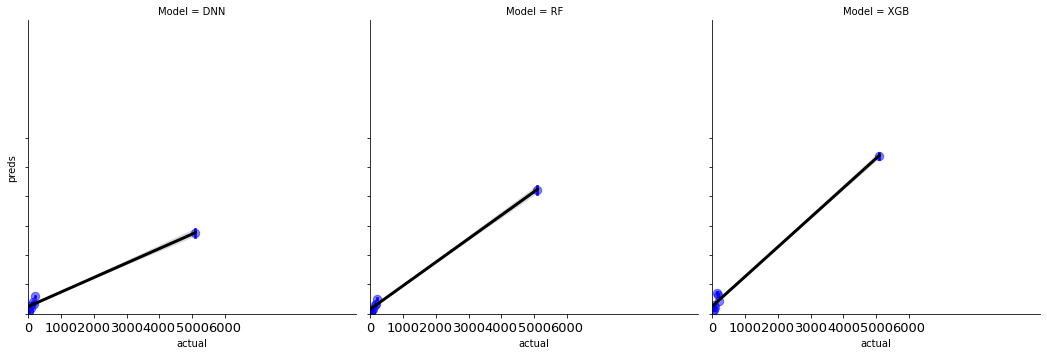

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/15
1190/1190 - 5s - loss: 1879410.0000 - mean_squared_error: 1879410.0000 - val_loss: 1472360.7500 - val_mean_squared_error: 1472360.7500
Epoch 2/15
1190/1190 - 5s - loss: 797801.7500 - mean_squared_error: 797801.7500 - val_loss: 2158485.5000 - val_mean_squared_error: 2158485.5000
Epoch 3/15
1190/1190 - 4s - loss: 592034.5625 - mean_squared_error: 592034.5625 - val_loss: 1833782.3750 - val_mean_squared_error: 1833782.3750
Epoch 4/15
1190/1190 - 4s - loss: 493022.5625 - mean_squared_error: 493022.5625 - val_loss: 1810320.3750 - val_mean_squared_error: 1810320.3750
Epoch 5/15
1190/1190 - 4s - loss: 437918.8750 - mean_squared_error: 437918.8750 - val_loss: 1642838.0000 - val_mean_squared_error: 1642838.0000
Epoch 6/15
1190/1190 - 5s - loss: 384318.5000 - mean_squared_error: 384318.5000 - val_loss: 1682426.1250 - val_mean_squared_error: 16

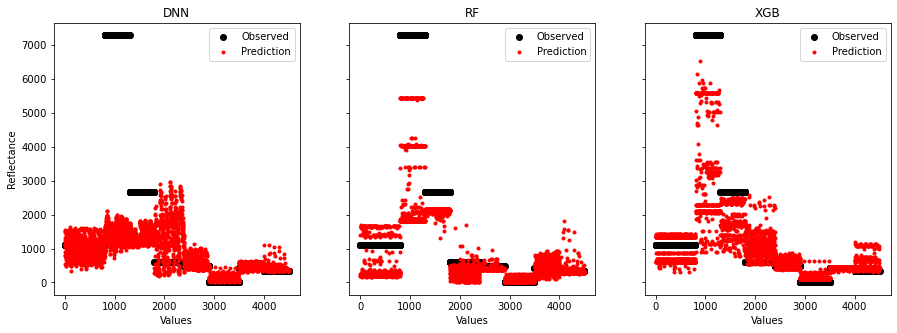

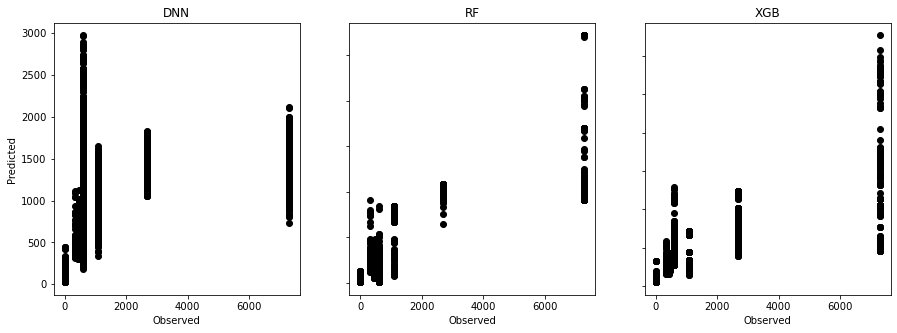

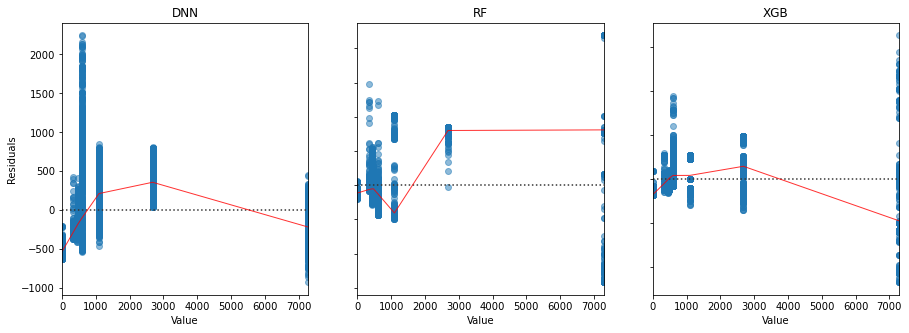

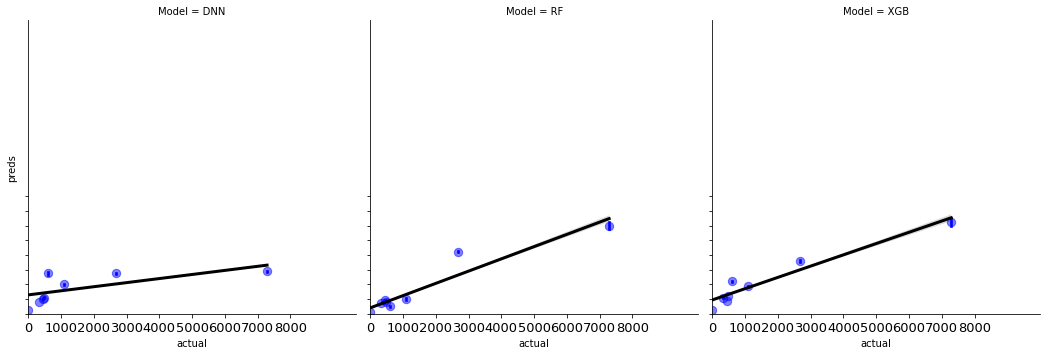

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/15
1153/1153 - 5s - loss: 1875441.7500 - mean_squared_error: 1875441.7500 - val_loss: 626195.5625 - val_mean_squared_error: 626195.5625
Epoch 2/15
1153/1153 - 4s - loss: 855621.5000 - mean_squared_error: 855621.5000 - val_loss: 4429284.0000 - val_mean_squared_error: 4429284.0000
Epoch 3/15
1153/1153 - 5s - loss: 634370.1875 - mean_squared_error: 634370.1875 - val_loss: 4183285.7500 - val_mean_squared_error: 4183285.7500
Epoch 4/15
1153/1153 - 5s - loss: 559940.0000 - mean_squared_error: 559940.0000 - val_loss: 4890220.5000 - val_mean_squared_error: 4890220.5000
Epoch 5/15
1153/1153 - 5s - loss: 509673.0625 - mean_squared_error: 509673.0625 - val_loss: 3954274.0000 - val_mean_squared_error: 3954274.0000
Epoch 6/15
1153/1153 - 4s - loss: 479984.4375 - mean_squared_error: 479984.4375 - val_loss: 2776787.0000 - val_mean_squared_error: 2776

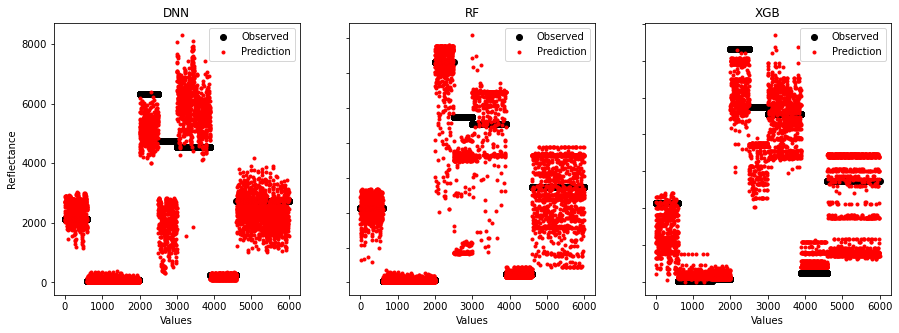

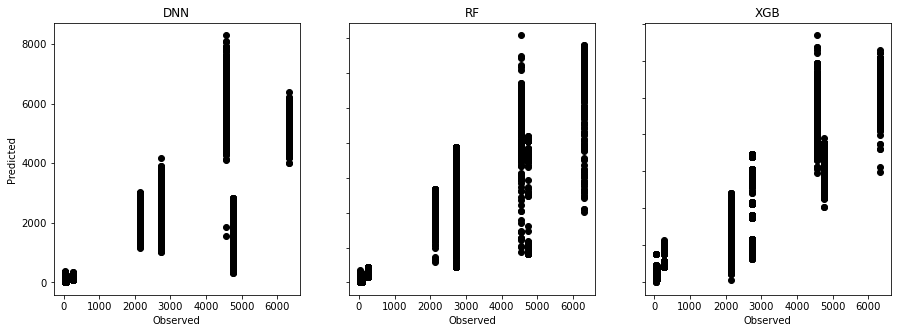

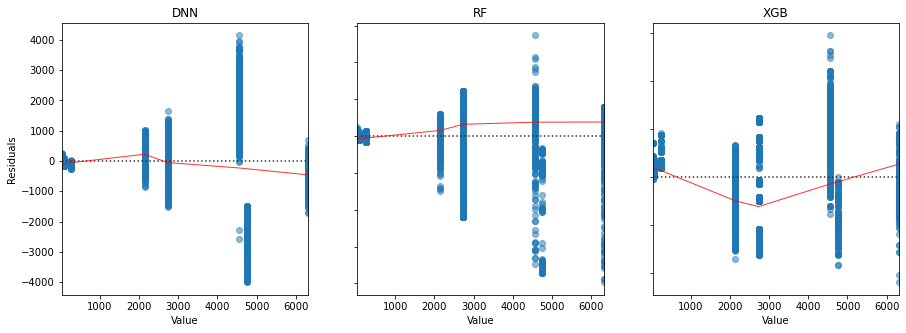

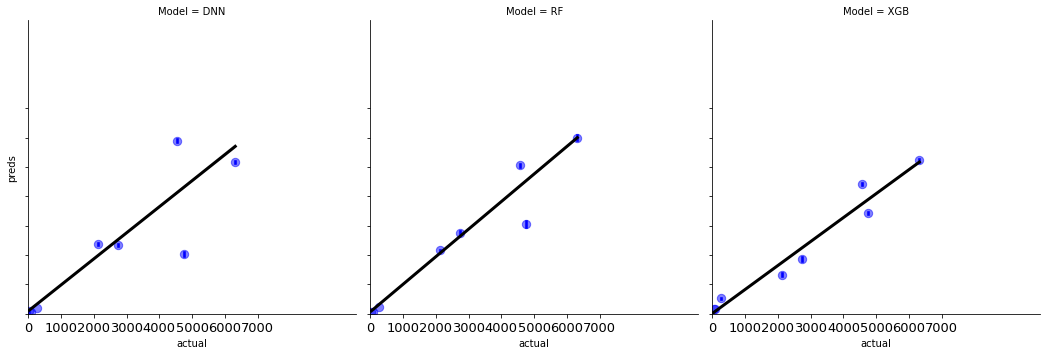

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/15
1193/1193 - 4s - loss: 1634729.0000 - mean_squared_error: 1634729.0000 - val_loss: 1008602.8750 - val_mean_squared_error: 1008602.8750
Epoch 2/15
1193/1193 - 5s - loss: 643421.3125 - mean_squared_error: 643421.3125 - val_loss: 1018506.3750 - val_mean_squared_error: 1018506.3750
Epoch 3/15
1193/1193 - 4s - loss: 506837.9375 - mean_squared_error: 506837.9375 - val_loss: 1336449.3750 - val_mean_squared_error: 1336449.3750
Epoch 4/15
1193/1193 - 4s - loss: 437558.5312 - mean_squared_error: 437558.5312 - val_loss: 1034917.8125 - val_mean_squared_error: 1034917.8125
Epoch 5/15
1193/1193 - 4s - loss: 388575.1250 - mean_squared_error: 388575.1250 - val_loss: 696380.3750 - val_mean_squared_error: 696380.3750
Epoch 6/15
1193/1193 - 4s - loss: 337715.7500 - mean_squared_error: 337715.7500 - val_loss: 727624.1250 - val_mean_squared_error: 72762

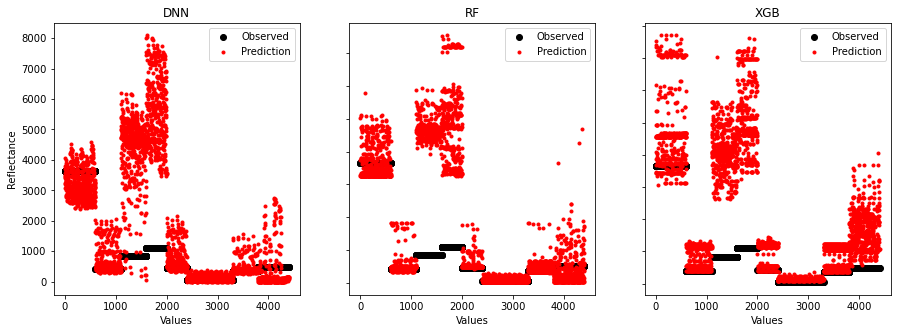

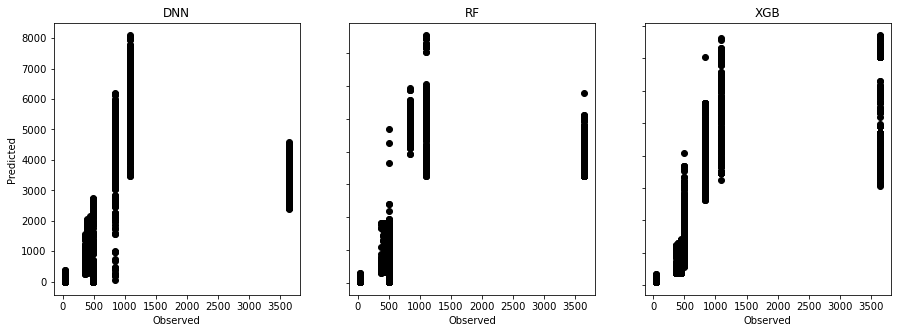

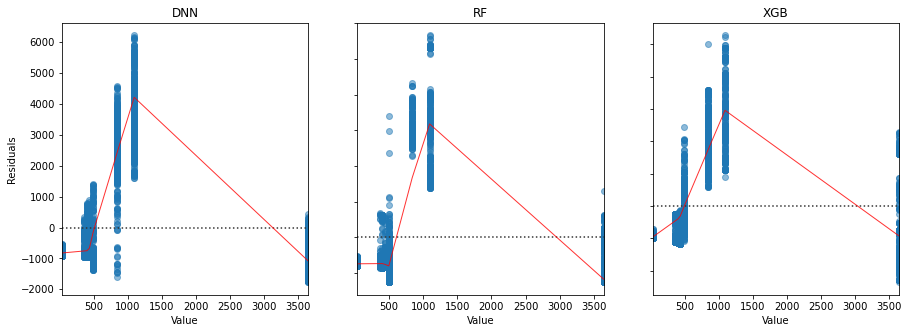

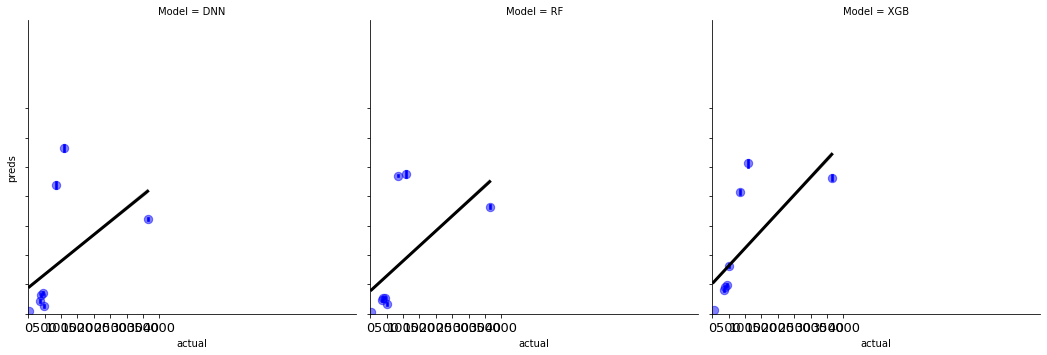

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/15
1165/1165 - 4s - loss: 1837458.2500 - mean_squared_error: 1837458.2500 - val_loss: 1539633.5000 - val_mean_squared_error: 1539633.5000
Epoch 2/15
1165/1165 - 4s - loss: 903835.5000 - mean_squared_error: 903835.5000 - val_loss: 1148767.7500 - val_mean_squared_error: 1148767.7500
Epoch 3/15
1165/1165 - 4s - loss: 686549.0625 - mean_squared_error: 686549.0625 - val_loss: 749496.7500 - val_mean_squared_error: 749496.7500
Epoch 4/15
1165/1165 - 4s - loss: 574942.5625 - mean_squared_error: 574942.5625 - val_loss: 765808.0625 - val_mean_squared_error: 765808.0625
Epoch 5/15
1165/1165 - 4s - loss: 527114.6875 - mean_squared_error: 527114.6875 - val_loss: 991373.0625 - val_mean_squared_error: 991373.0625
Epoch 6/15
1165/1165 - 4s - loss: 473520.0000 - mean_squared_error: 473520.0000 - val_loss: 750508.6875 - val_mean_squared_error: 750508.68

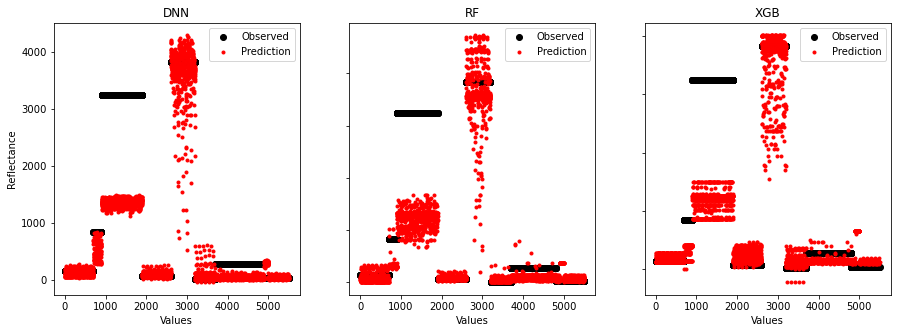

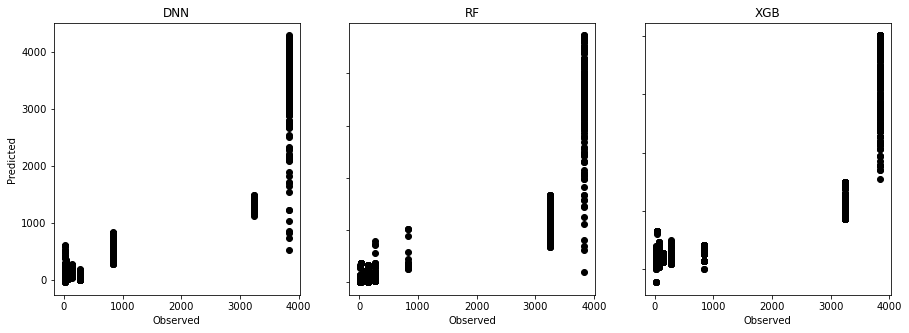

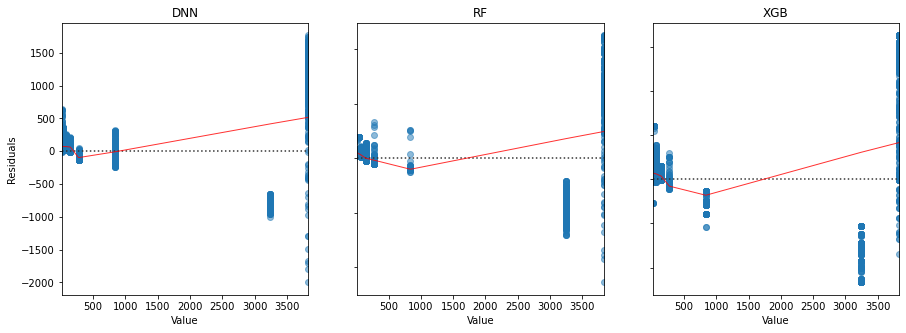

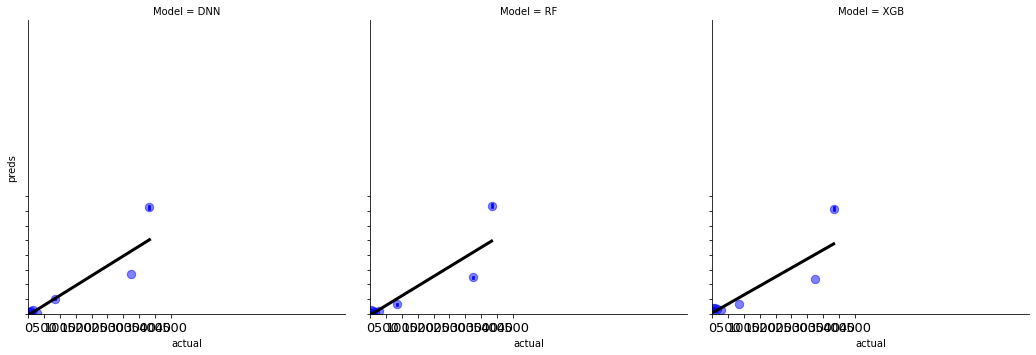

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/15
1183/1183 - 4s - loss: 1870170.3750 - mean_squared_error: 1870170.3750 - val_loss: 990386.1875 - val_mean_squared_error: 990386.1875
Epoch 2/15
1183/1183 - 4s - loss: 860262.3750 - mean_squared_error: 860262.3750 - val_loss: 1650929.8750 - val_mean_squared_error: 1650929.8750
Epoch 3/15
1183/1183 - 4s - loss: 676873.6250 - mean_squared_error: 676873.6250 - val_loss: 1882837.5000 - val_mean_squared_error: 1882837.5000
Epoch 4/15
1183/1183 - 4s - loss: 595333.3750 - mean_squared_error: 595333.3750 - val_loss: 1917996.1250 - val_mean_squared_error: 1917996.1250
Epoch 5/15
1183/1183 - 4s - loss: 536339.2500 - mean_squared_error: 536339.2500 - val_loss: 1453932.3750 - val_mean_squared_error: 1453932.3750
Epoch 6/15
1183/1183 - 4s - loss: 477880.1250 - mean_squared_error: 477880.1250 - val_loss: 1933410.2500 - val_mean_squared_error: 1933

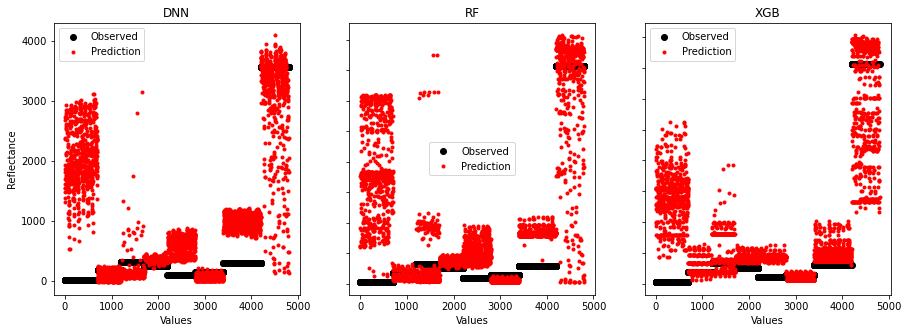

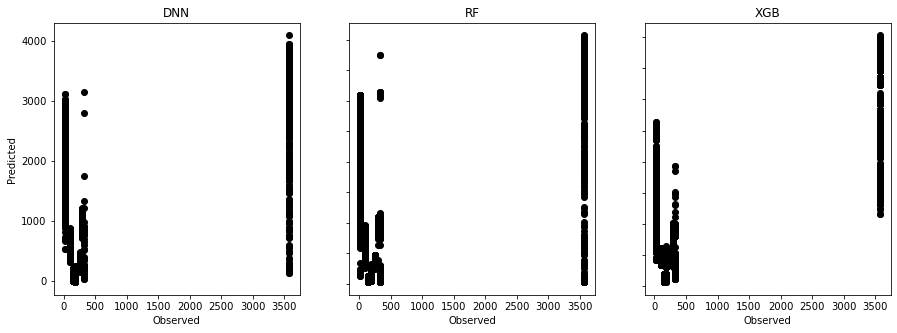

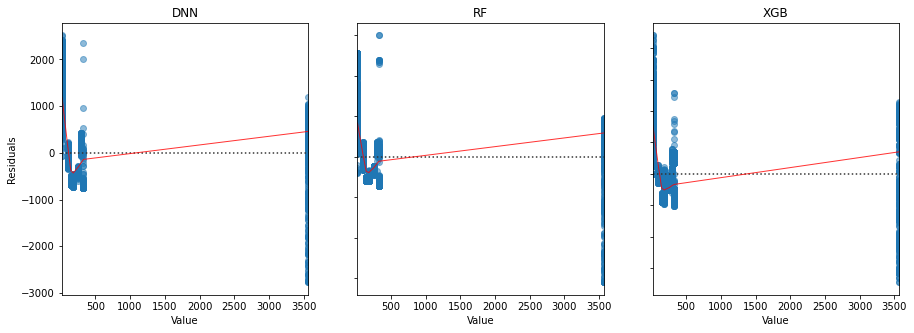

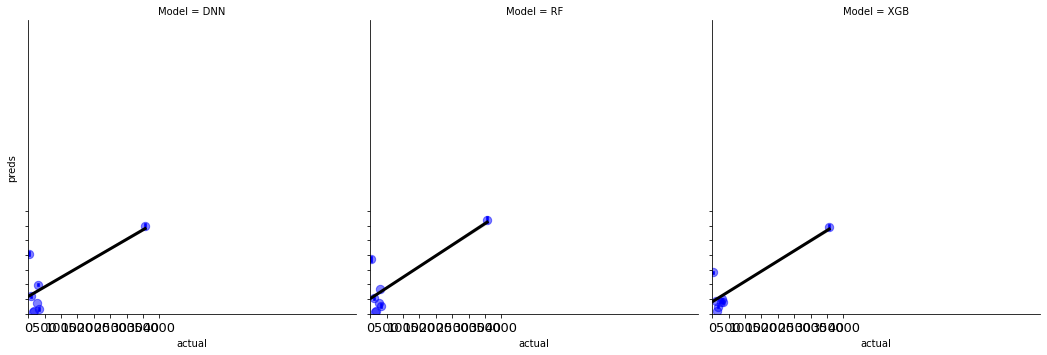

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/15
1195/1195 - 6s - loss: 1809262.5000 - mean_squared_error: 1809262.5000 - val_loss: 1191840.7500 - val_mean_squared_error: 1191840.7500
Epoch 2/15
1195/1195 - 5s - loss: 723908.0000 - mean_squared_error: 723908.0000 - val_loss: 1999042.5000 - val_mean_squared_error: 1999042.5000
Epoch 3/15
1195/1195 - 5s - loss: 566360.6875 - mean_squared_error: 566360.6875 - val_loss: 1447724.7500 - val_mean_squared_error: 1447724.7500
Epoch 4/15
1195/1195 - 6s - loss: 494401.7812 - mean_squared_error: 494401.7812 - val_loss: 1279458.2500 - val_mean_squared_error: 1279458.2500
Epoch 5/15
1195/1195 - 5s - loss: 450444.6250 - mean_squared_error: 450444.6250 - val_loss: 1051646.1250 - val_mean_squared_error: 1051646.1250
Epoch 6/15
1195/1195 - 4s - loss: 420202.7188 - mean_squared_error: 420202.7188 - val_loss: 1053523.2500 - val_mean_squared_error: 10

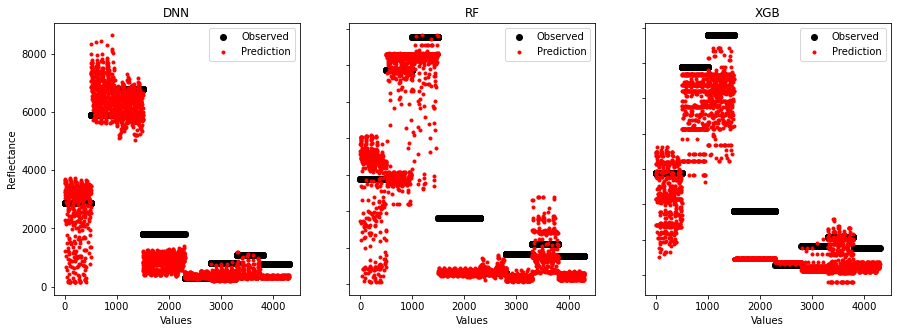

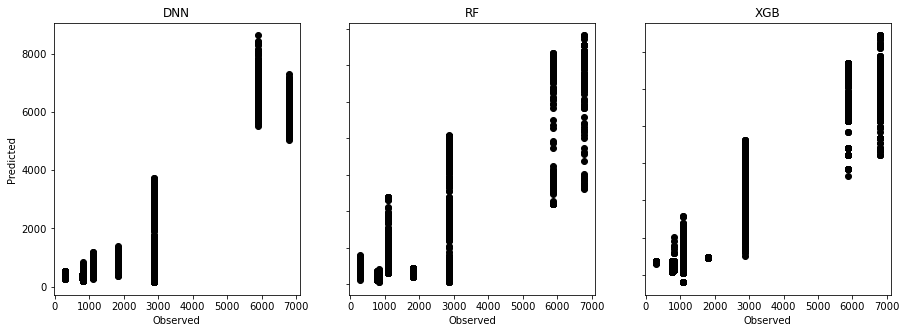

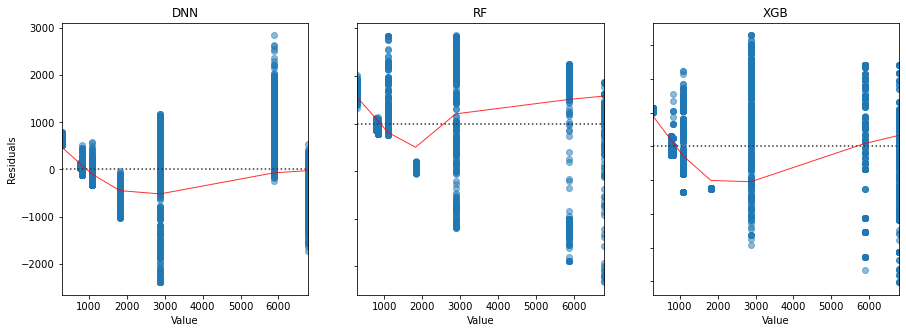

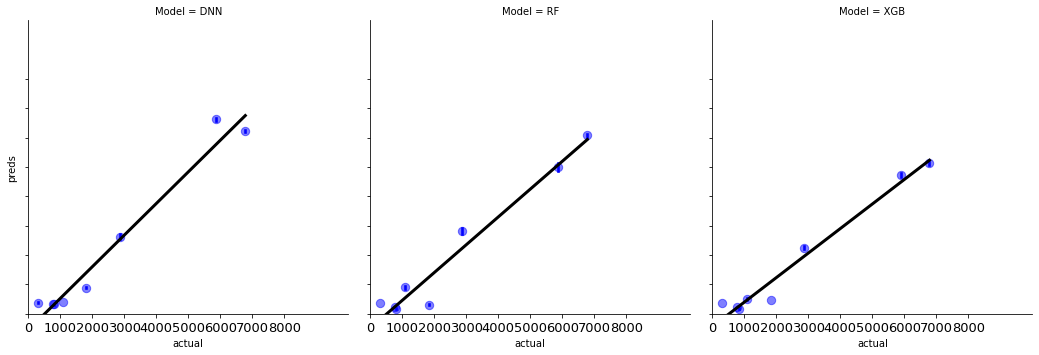

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/15
1135/1135 - 4s - loss: 1397585.5000 - mean_squared_error: 1397585.5000 - val_loss: 865108.2500 - val_mean_squared_error: 865108.2500
Epoch 2/15
1135/1135 - 4s - loss: 908122.8750 - mean_squared_error: 908122.8750 - val_loss: 2936027.7500 - val_mean_squared_error: 2936027.7500
Epoch 3/15
1135/1135 - 4s - loss: 746569.4375 - mean_squared_error: 746569.4375 - val_loss: 4296147.5000 - val_mean_squared_error: 4296147.5000
Epoch 4/15
1135/1135 - 4s - loss: 614126.6250 - mean_squared_error: 614126.6250 - val_loss: 3036991.5000 - val_mean_squared_error: 3036991.5000
Epoch 5/15
1135/1135 - 4s - loss: 529299.5000 - mean_squared_error: 529299.5000 - val_loss: 3844237.2500 - val_mean_squared_error: 3844237.2500
Epoch 6/15
1135/1135 - 4s - loss: 467667.5000 - mean_squared_error: 467667.5000 - val_loss: 1411799.1250 - val_mean_squared_error: 1411

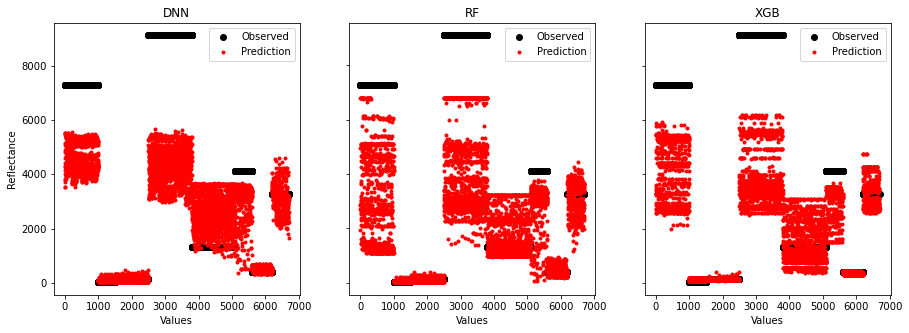

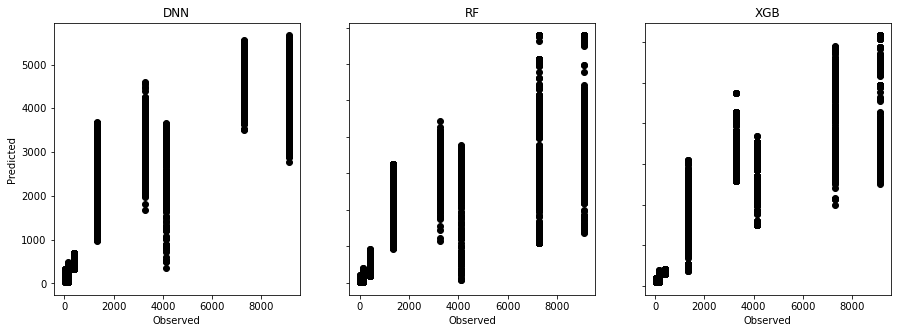

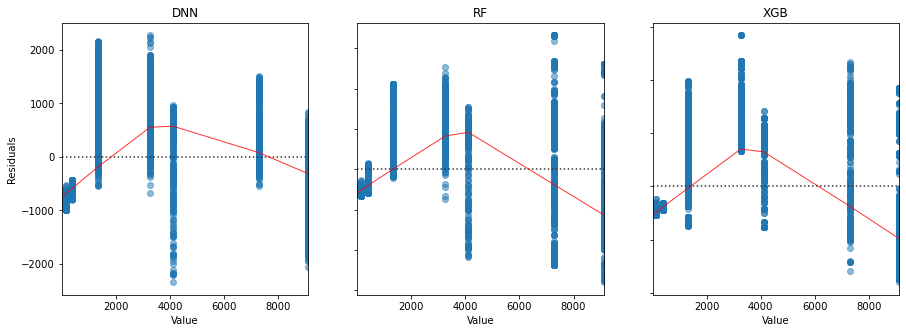

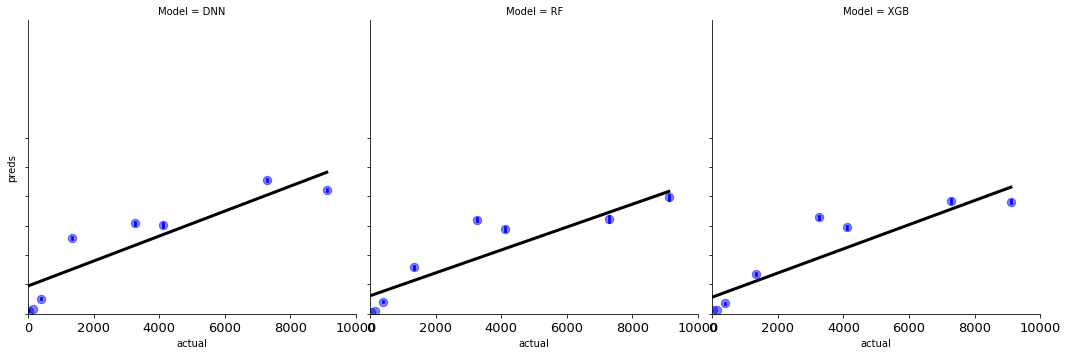

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/15
1140/1140 - 4s - loss: 1511326.0000 - mean_squared_error: 1511326.0000 - val_loss: 753770.4375 - val_mean_squared_error: 753770.4375
Epoch 2/15
1140/1140 - 4s - loss: 645222.2500 - mean_squared_error: 645222.2500 - val_loss: 980221.0625 - val_mean_squared_error: 980221.0625
Epoch 3/15
1140/1140 - 4s - loss: 385644.8125 - mean_squared_error: 385644.8125 - val_loss: 922868.1875 - val_mean_squared_error: 922868.1875
Epoch 4/15
1140/1140 - 4s - loss: 316742.1250 - mean_squared_error: 316742.1250 - val_loss: 996263.6250 - val_mean_squared_error: 996263.6250
Epoch 5/15
1140/1140 - 4s - loss: 289743.8750 - mean_squared_error: 289743.8750 - val_loss: 1231879.7500 - val_mean_squared_error: 1231879.7500
Epoch 6/15
1140/1140 - 4s - loss: 260976.4844 - mean_squared_error: 260976.4844 - val_loss: 1125749.8750 - val_mean_squared_error: 1125749.87

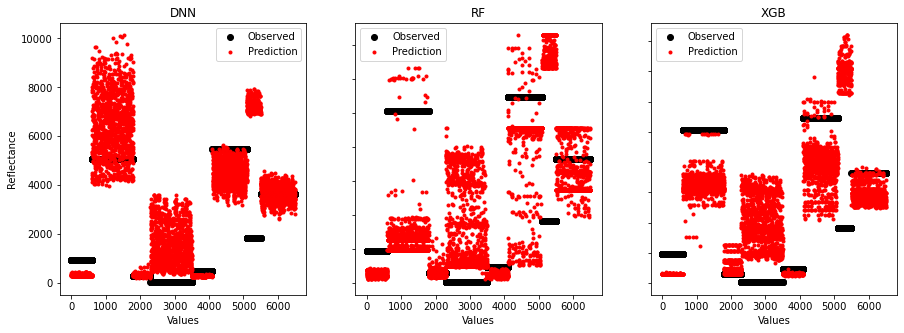

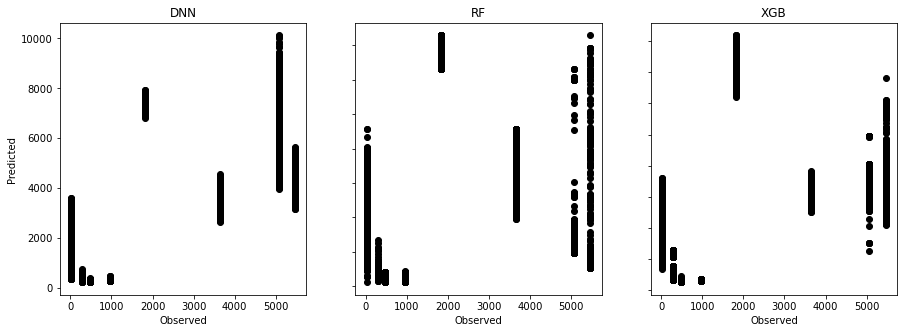

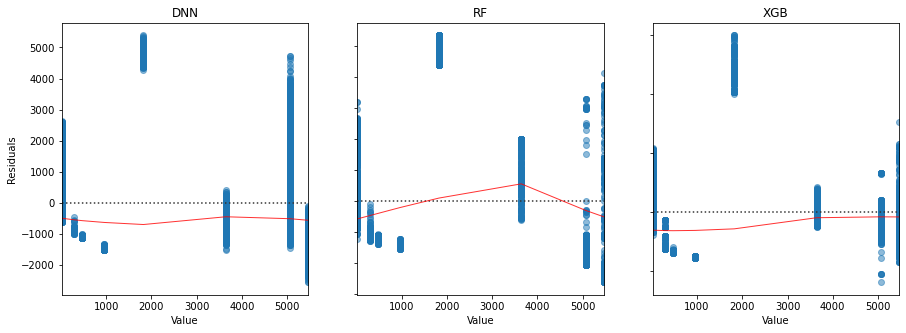

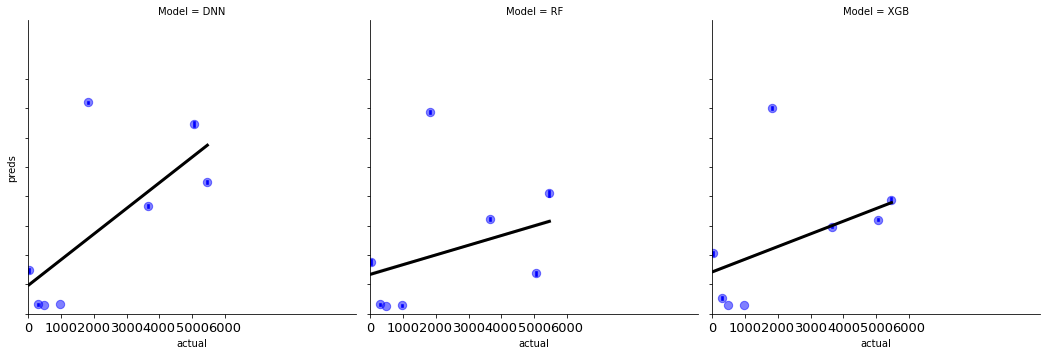

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/15
1190/1190 - 4s - loss: 1904769.5000 - mean_squared_error: 1904769.5000 - val_loss: 985925.2500 - val_mean_squared_error: 985925.2500
Epoch 2/15
1190/1190 - 4s - loss: 935335.6875 - mean_squared_error: 935335.6875 - val_loss: 2322015.0000 - val_mean_squared_error: 2322015.0000
Epoch 3/15
1190/1190 - 4s - loss: 733608.5000 - mean_squared_error: 733608.5000 - val_loss: 2173365.5000 - val_mean_squared_error: 2173365.5000
Epoch 4/15
1190/1190 - 4s - loss: 618690.1875 - mean_squared_error: 618690.1875 - val_loss: 1938320.7500 - val_mean_squared_error: 1938320.7500
Epoch 5/15
1190/1190 - 4s - loss: 576423.5000 - mean_squared_error: 576423.5000 - val_loss: 1646897.7500 - val_mean_squared_error: 1646897.7500
Epoch 6/15
1190/1190 - 4s - loss: 533261.6250 - mean_squared_error: 533261.6250 - val_loss: 1244538.1250 - val_mean_squared_error: 1244

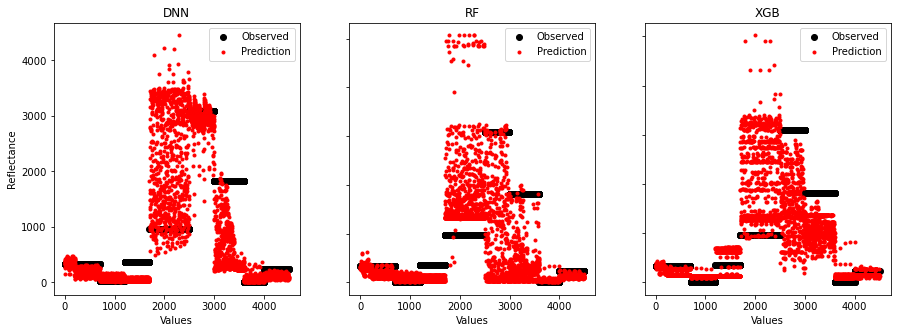

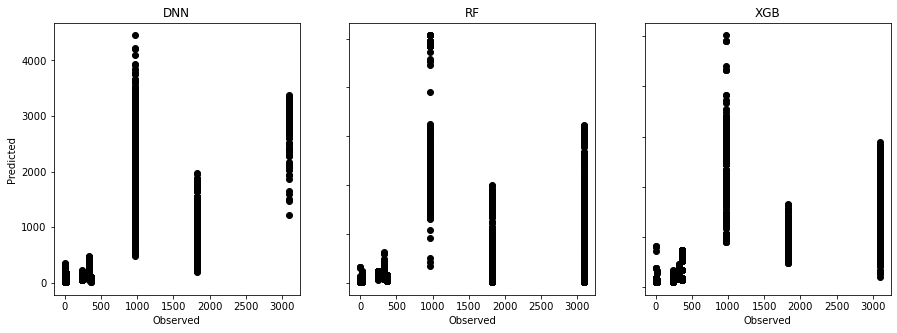

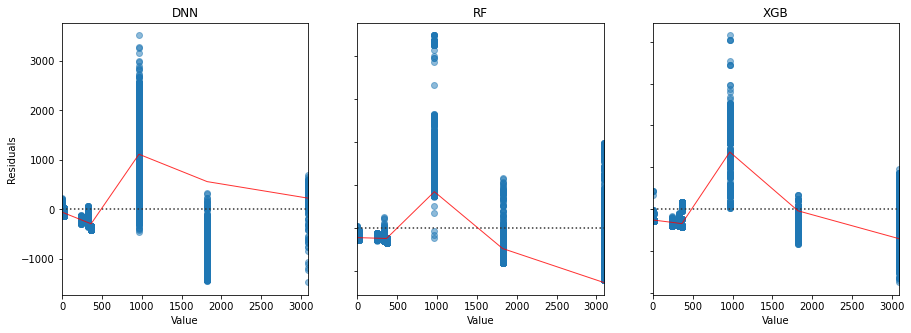

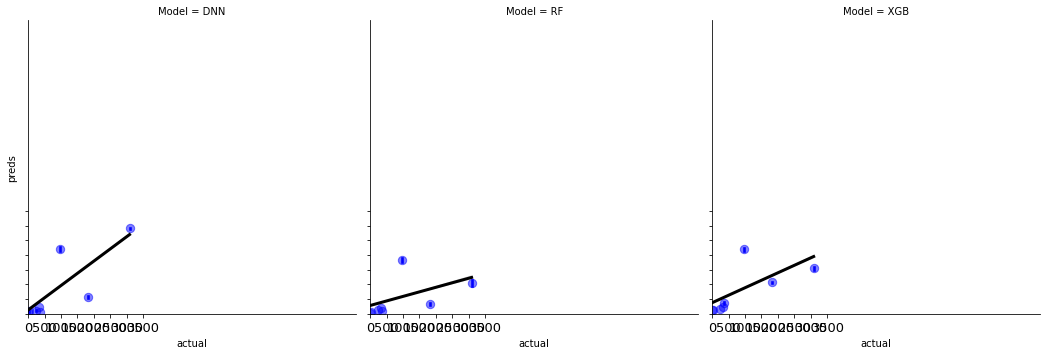

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - R2 Scores for DNN: 65.0% - RF: 84.0% - XGB: 89.0%
> Fold 1 - MAE Scores for DNN: 393.3 - RF: 247.75 - XGB: 341.54
------------------------------------------------------------------------
> Fold 2 - R2 Scores for DNN: 12.0% - RF: 48.0% - XGB: 50.0%
> Fold 2 - MAE Scores for DNN: 999.6 - RF: 764.42 - XGB: 756.43
------------------------------------------------------------------------
> Fold 3 - R2 Scores for DNN: 71.0% - RF: 82.0% - XGB: 77.0%
> Fold 3 - MAE Scores for DNN: 710.82 - RF: 554.67 - XGB: 730.83
------------------------------------------------------------------------
> Fold 4 - R2 Scores for DNN: -190.0% - RF: -146.0% - XGB: -174.0%
> Fold 4 - MAE Scores for DNN: 1046.7 - RF: 937.12 - XGB: 1226.85
------------------------------------------------------------------------
> Fold 5 - R2 Scores for DNN: 69.0% - 

In [40]:
# Define per-fold score containers
R2_per_fold_DNN = []
MAE_per_fold_DNN = []
R2_per_fold_RF = []
MAE_per_fold_RF = []
R2_per_fold_XGB = []
MAE_per_fold_XGB = []

W_dir = './ModelDatabase/Trained_Weights'
for f in os.listdir(W_dir):
    os.remove(os.path.join(W_dir, f))
# fix random seed for reproducibility
seed = 7

# define standard scaler
scaler = StandardScaler()

for fold in range(len(Kfold_T_inputs)):
    
    fold_no = fold + 1
    Valid_inputs = np.array([np.array(xi) for xi in Kfold_V_inputs[fold]]) 
    Valid_targets = np.array(Kfold_V_targets[fold])
    Train_inputs = np.array([np.array(xi) for xi in Kfold_T_inputs[fold]])
    Train_targets = np.array(Kfold_T_targets[fold])
    print(type(Train_inputs))
    print(type(Train_targets))
    model = Sequential()
    #model.add(Dropout(0.2, input_shape=(5,)))
    model.add(Dense(128, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) #mean_squared_error
    model_RF = RandomForestRegressor()
    XGBModel = XGBRegressor(verbosity=0)
    #XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #   colsample_bynode=1, colsample_bytree=1, gamma=0,
    #   importance_type='gain', learning_rate=0.1, max_delta_step=0,
    #   max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
    #   n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
    #   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
    #   silent=None, subsample=1, verbosity=1)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no-1} ...')
    # callbacks
    checkpoint_name = './ModelDatabase/Trained_Weights/Weights-fold'+str(fold_no)+'-ep{epoch:03d}--loss{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose =0, save_best_only = True, mode ='auto')    
    callbacks_list = [checkpoint] #tensorboard_callback
    # transform data
    train_X = scaler.fit_transform(Train_inputs)
    valid_X = scaler.transform(Valid_inputs)
    #print(Kfold_T_targets)
    pickle.dump(scaler, open(W_dir+'/std_scaler_Fold_'+ str(fold_no) +'.pkl', 'wb'))
    # Fit data to model
    model.fit(train_X, Train_targets, epochs=15, batch_size=32, validation_split = 0.2, callbacks=callbacks_list, verbose=2)  
    model_RF.fit(train_X, Train_targets)
    XGBModel.fit(train_X, Train_targets, verbose=False)
    pickle.dump(model_RF, open(W_dir+'/RF_model_Fold_'+ str(fold_no) +'.sav', 'wb'))
    pickle.dump(XGBModel, open(W_dir+'/XGB_model_Fold_'+ str(fold_no) +'.sav', 'wb'))
    # Generate generalization metrics
    #scores = model.evaluate(valid_X, Kfold_V_targets, verbose=2)
    preds = model.predict(valid_X, verbose=0)
    preds_RF = model_RF.predict(valid_X)
    preds_XGB = XGBModel.predict(valid_X)
    #correlation_matrix = np.corrcoef(preds.flatten(), Kfold_V_targets)
    #correlation_xy = correlation_matrix[0,1]
    #scores = correlation_xy**2
    r2_DNN = round(r2_score(Valid_targets, preds.flatten()), 2)
    mae_DNN = round(mean_absolute_error(Valid_targets, preds.flatten()), 2)
    r2_RF = round(r2_score(Valid_targets, preds_RF.flatten()), 2)
    mae_RF = round(mean_absolute_error(Valid_targets, preds_RF.flatten()), 2)
    r2_XGB = round(r2_score(Valid_targets, preds_XGB.flatten()), 2)
    mae_XGB = round(mean_absolute_error(Valid_targets, preds_XGB.flatten()), 2)
    
    print(color.BOLD + color.BLUE + f'R2 Scores for fold {fold_no}: DNN of {r2_DNN*100}%; RF of {r2_RF*100}%; XGB of {r2_XGB*100}%'+ color.END)                        
    print(color.BOLD + color.BLUE + f'MAE Scores for fold {fold_no}: DNN of {mae_DNN}; RF of {mae_RF}; XGB of {mae_XGB}'+ color.END)
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].plot(np.arange(len(Valid_targets)), Valid_targets, 'o', color='black', label="Observed")  
    axs[0].plot(np.arange(len(preds.flatten())), preds.flatten(), '.', color='red', label="Prediction")
    axs[0].set_title('DNN')
    axs[1].plot(np.arange(len(Valid_targets)), Valid_targets, 'o', color='black', label="Observed")
    axs[1].plot(np.arange(len(preds_RF.flatten())), preds_RF.flatten(), '.', color='red', label="Prediction")
    axs[1].set_title('RF')
    axs[2].plot(np.arange(len(Valid_targets)), Valid_targets, 'o', color='black', label="Observed")
    axs[2].plot(np.arange(len(preds_XGB.flatten())), preds_XGB.flatten(), '.', color='red', label="Prediction")
    axs[2].set_title('XGB')
    
    for ax in axs.flat:
        ax.set(xlabel='Values', ylabel='Reflectance')
    for ax in axs.flat:
        ax.label_outer()
        ax.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].plot(Valid_targets, preds.flatten(), 'o', color='black')  
    axs[0].set_title('DNN')
    axs[1].plot(Valid_targets, preds_RF.flatten(), 'o', color='black')
    axs[1].set_title('RF')
    axs[2].plot(Valid_targets, preds_XGB.flatten(), 'o', color='black')
    axs[2].set_title('XGB')
    
    for ax in axs.flat:
        ax.set(xlabel='Observed', ylabel='Predicted')
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    sb.residplot(Valid_targets, preds.flatten(), 
                          ax =axs[0],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[0].set_title('DNN')
    sb.residplot(Valid_targets, preds_RF.flatten(), 
                          ax =axs[1],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[1].set_title('RF')
    sb.residplot(Valid_targets, preds_XGB.flatten(), 
                          ax =axs[2],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[2].set_title('XGB')
    
    for ax in axs.flat:
        ax.set(xlabel='Value', ylabel='Residuals')
    for ax in axs.flat:
        ax.label_outer()
    plt.show()
    
    #fig, axs = plt.subplots(1, 1, figsize=(15,5))
    dic = {
        'actual': Valid_targets,
        'preds': preds.flatten(),
        'Model': ['DNN'] * len(Valid_targets)
        }
    data1 = pd.DataFrame(dic)
    dic = {
        'actual': Valid_targets,
        'preds': preds_RF.flatten(),
        'Model': ['RF'] * len(Valid_targets)
        }
    data2 = pd.DataFrame(dic)
    dic = {
        'actual': Valid_targets,
        'preds': preds_XGB.flatten(),
        'Model': ['XGB'] * len(Valid_targets)
        }
    data3 = pd.DataFrame(dic)
    joined = pd.concat([data1, data2, data3])
    b = sb.lmplot(x="actual", y="preds", col="Model", data=joined, x_estimator=np.mean, 
                  scatter_kws={'color': 'blue', 'alpha':0.5, 's':70}, 
                  line_kws={"linewidth": 3, 'color': 'black'})  

    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    b.set_yticklabels(ylabels, size=13)
    b.set_xticklabels(xlabels, size=13)
    b.set(xlim=(0,10000),ylim=(0,10000))
    plt.show()
    
    R2_per_fold_DNN.append(r2_DNN * 100)
    MAE_per_fold_DNN.append(mae_DNN)
    R2_per_fold_RF.append(r2_RF * 100)
    MAE_per_fold_RF.append(mae_RF)
    R2_per_fold_XGB.append(r2_XGB * 100)
    MAE_per_fold_XGB.append(mae_XGB)
    

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(R2_per_fold_DNN)):
    print('------------------------------------------------------------------------')
    print(color.BOLD + color.BLUE + f'> Fold {i+1} - R2 Scores for DNN: {R2_per_fold_DNN[i]}% - RF: {R2_per_fold_RF[i]}% - XGB: {R2_per_fold_XGB[i]}%' + color.END)    
    print(color.BOLD + color.BLUE + f'> Fold {i+1} - MAE Scores for DNN: {MAE_per_fold_DNN[i]} - RF: {MAE_per_fold_RF[i]} - XGB: {MAE_per_fold_XGB[i]}' + color.END)    
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(color.BOLD + color.YELLOW + f'> R2 for DNN: {round(np.mean(R2_per_fold_DNN), 2)} (+- {round(np.std(R2_per_fold_DNN), 2)}) RF: {round(np.mean(R2_per_fold_RF), 2)} (+- {round(np.std(R2_per_fold_RF), 2)}) XGB: {round(np.mean(R2_per_fold_XGB), 2)} (+- {round(np.std(R2_per_fold_XGB), 2)})' + color.END)        
print(color.BOLD + color.YELLOW + f'> R2 for DNN: {round(np.mean(MAE_per_fold_DNN), 2)} (+- {round(np.std(MAE_per_fold_DNN), 2)}) RF: {round(np.mean(MAE_per_fold_RF), 2)} (+- {round(np.std(MAE_per_fold_RF), 2)}) XGB: {round(np.mean(MAE_per_fold_XGB), 2)} (+- {round(np.std(MAE_per_fold_XGB), 2)})' + color.END)        
print('------------------------------------------------------------------------')


In [40]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = Train_Data.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_151 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_152 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_153 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 257       
Total params: 165,633
Trainable params: 165,633
Non-trainable params: 0
_________________________________________________________________


In [76]:
# fix random seed for reproducibility
seed = 7

!rm -rf ./logs/

W_dir = './ModelDatabase/Trained_Weights'
for f in os.listdir(W_dir):
    os.remove(os.path.join(W_dir, f))
    
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(5,)))
    model.add(Dense(128, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
# evaluate model
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_name = './ModelDatabase/Trained_Weights/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose =0, save_best_only = True, mode ='auto')    
callbacks_list = [checkpoint] #tensorboard_callback
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=3, batch_size=32, verbose=2)))   #, callbacks=callbacks_list
pipeline = Pipeline(estimators)
kfold = KFold(n_splits = 5)

results = cross_val_score(pipeline, inputs, targets, cv = kfold) # fit_params={'mlp__callbacks':callbacks_list}
print("\n Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/3
918/918 - 3s - loss: 9177274.0000
Epoch 2/3
918/918 - 3s - loss: 9177257.0000
Epoch 3/3
918/918 - 3s - loss: 9177253.0000
230/230 - 0s - loss: 6316852.0000
Epoch 1/3
918/918 - 3s - loss: 8752556.0000
Epoch 2/3
918/918 - 3s - loss: 8752541.0000
Epoch 3/3
918/918 - 4s - loss: 8752537.0000
230/230 - 0s - loss: 8015738.5000
Epoch 1/3
918/918 - 3s - loss: 8762076.0000
Epoch 2/3
918/918 - 3s - loss: 8762064.0000
Epoch 3/3
918/918 - 3s - loss: 8762069.0000
230/230 - 0s - loss: 7977620.0000
Epoch 1/3
918/918 - 3s - loss: 9135381.0000
Epoch 2/3
918/918 - 3s - loss: 9135361.0000
Epoch 3/3
918/918 - 3s - loss: 9135367.0000
230/230 - 0s - loss: 6484426.0000
Epoch 1/3
918/918 - 3s - loss: 7198677.5000
Epoch 2/3
918/918 - 3s - loss: 7198662.0000
Epoch 3/3
918/918 - 3s - loss: 7198659.5000
230/230 - 0s - loss: 14231242.0000

 Baseline: -8605175.70 (2902684.59) MSE


------------------------------------------------------------------------
Training for fold 1 ...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/20
1042/1042 - 5s - loss: 1776017.2500 - mean_squared_error: 1776017.2500 - val_loss: 835956.7500 - val_mean_squared_error: 835956.7500
Epoch 2/20
1042/1042 - 5s - loss: 835972.3125 - mean_squared_error: 835972.3125 - val_loss: 731341.9375 - val_mean_squared_error: 731341.9375
Epoch 3/20
1042/1042 - 5s - loss: 629220.9375 - mean_squared_error: 629220.9375 - val_loss: 662928.5000 - val_mean_squared_error: 662928.5000
Epoch 4/20
1042/1042 - 5s - loss: 540941.4375 - mean_squared_error: 540941.4375 - val_loss: 533406.5000 - val_mean_squared_error: 533406.5000
Epoch 5/20
1042/1042 - 5s - loss: 482489.5312 - mean_squared_error: 482489.5312 - val_loss: 516218.9688 - val_mean_squared_error: 516218.9688
Epoch 6/20
1042/1042 - 5s - loss: 426616.0000 - mean_squared_error: 426616.0000 - val_loss: 486988.1250 - val_mean_squared_error: 486988.1250
E

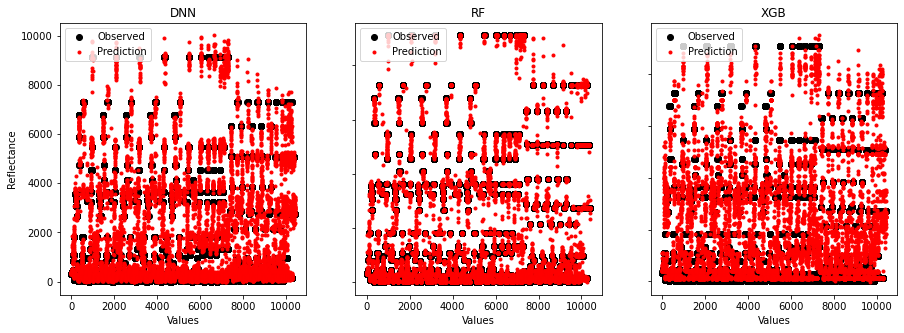

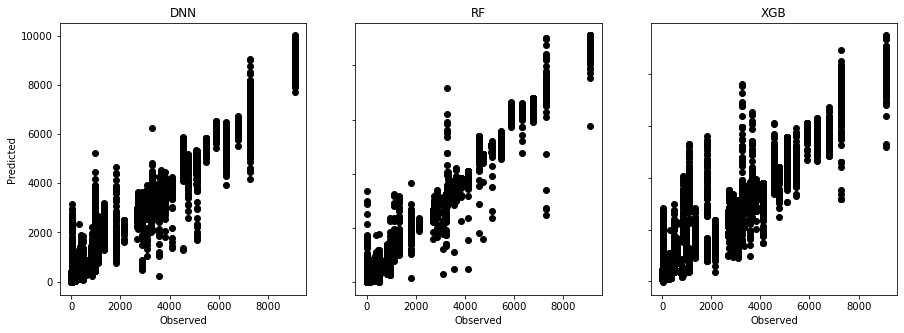

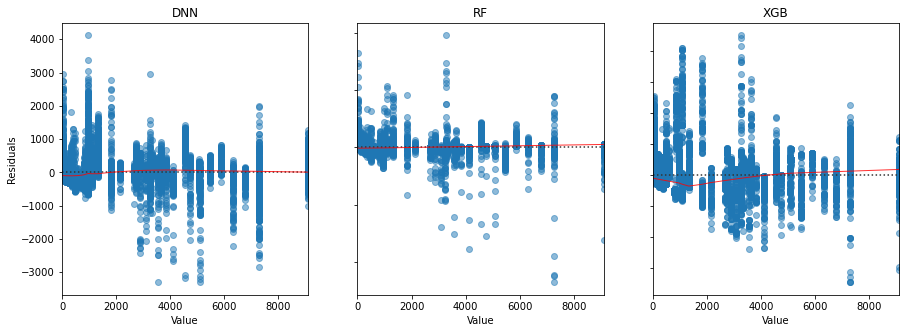

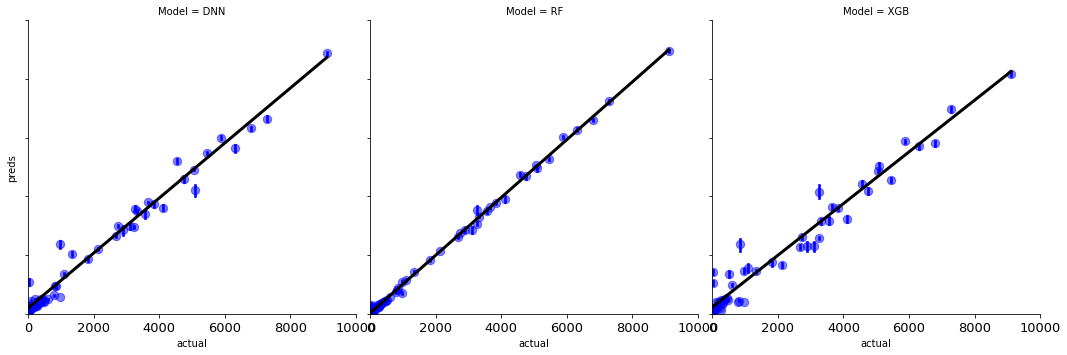

------------------------------------------------------------------------
Training for fold 2 ...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/20
1042/1042 - 5s - loss: 1778549.7500 - mean_squared_error: 1778549.7500 - val_loss: 962721.5625 - val_mean_squared_error: 962721.5625
Epoch 2/20
1042/1042 - 5s - loss: 846182.1250 - mean_squared_error: 846182.1250 - val_loss: 669678.0000 - val_mean_squared_error: 669678.0000
Epoch 3/20
1042/1042 - 4s - loss: 642540.2500 - mean_squared_error: 642540.2500 - val_loss: 514981.0938 - val_mean_squared_error: 514981.0938
Epoch 4/20
1042/1042 - 5s - loss: 569197.8125 - mean_squared_error: 569197.8125 - val_loss: 480840.1875 - val_mean_squared_error: 480840.1875
Epoch 5/20
1042/1042 - 6s - loss: 532694.0625 - mean_squared_error: 532694.0625 - val_loss: 574851.1875 - val_mean_squared_error: 574851.1875
Epoch 6/20
1042/1042 - 5s - loss: 499524.6562 - mean_squared_error: 499524.6562 - val_loss: 375038.2812 - val_mean_squared_error: 375038.2812
E

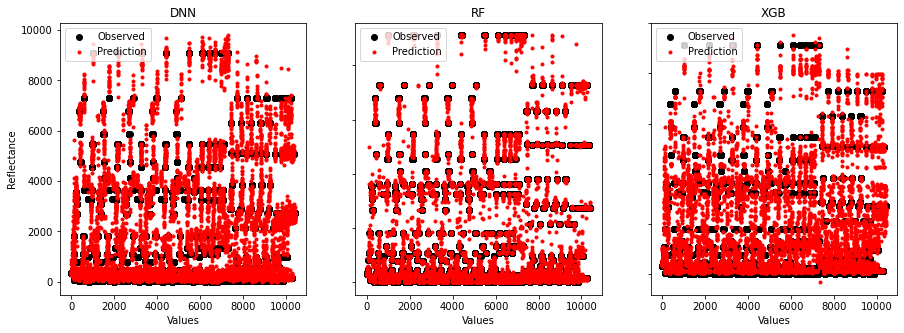

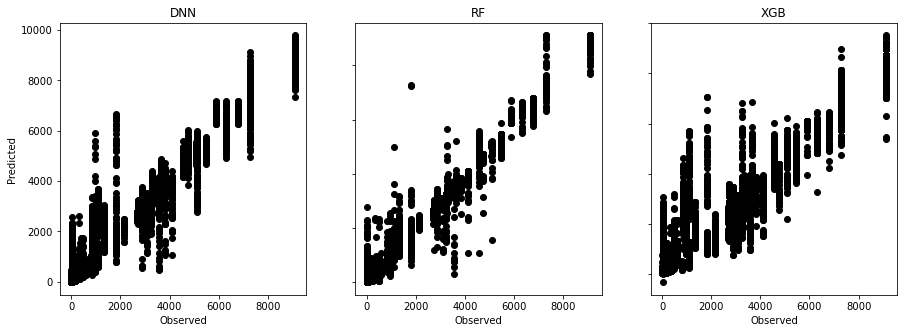

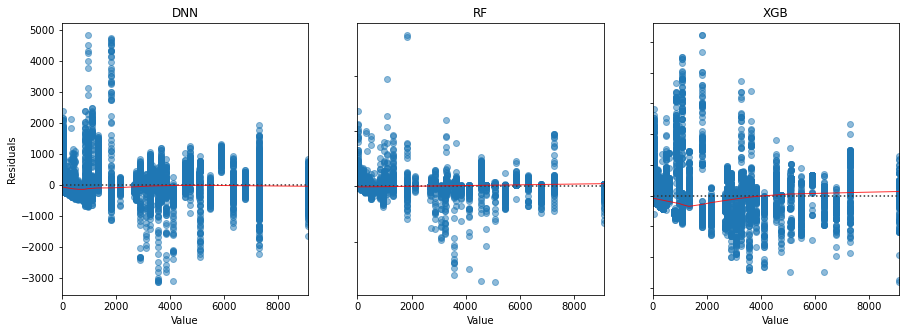

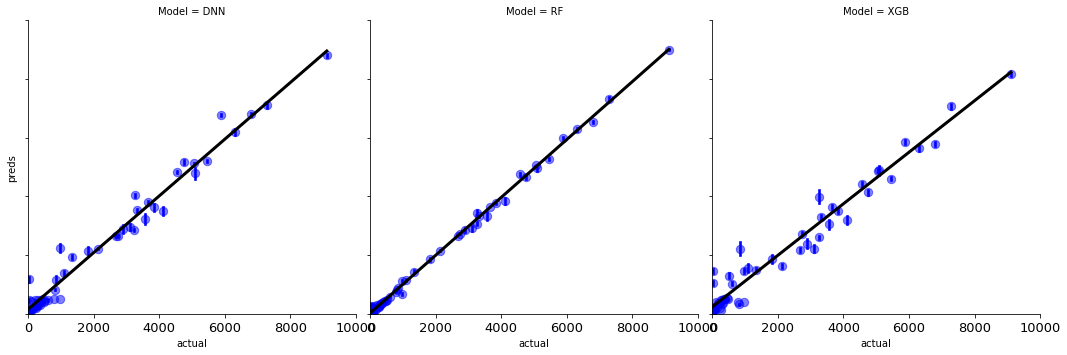

------------------------------------------------------------------------
Training for fold 3 ...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/20
1042/1042 - 5s - loss: 1804074.7500 - mean_squared_error: 1804074.7500 - val_loss: 659477.7500 - val_mean_squared_error: 659477.7500
Epoch 2/20
1042/1042 - 5s - loss: 807098.6875 - mean_squared_error: 807098.6875 - val_loss: 633677.5000 - val_mean_squared_error: 633677.5000
Epoch 3/20
1042/1042 - 4s - loss: 635774.9375 - mean_squared_error: 635774.9375 - val_loss: 424644.8125 - val_mean_squared_error: 424644.8125
Epoch 4/20
1042/1042 - 5s - loss: 564801.5000 - mean_squared_error: 564801.5000 - val_loss: 445159.3438 - val_mean_squared_error: 445159.3438
Epoch 5/20
1042/1042 - 5s - loss: 519823.1562 - mean_squared_error: 519823.1562 - val_loss: 430999.2812 - val_mean_squared_error: 430999.2812
Epoch 6/20
1042/1042 - 5s - loss: 469405.9062 - mean_squared_error: 469405.9062 - val_loss: 392009.3125 - val_mean_squared_error: 392009.3125
E

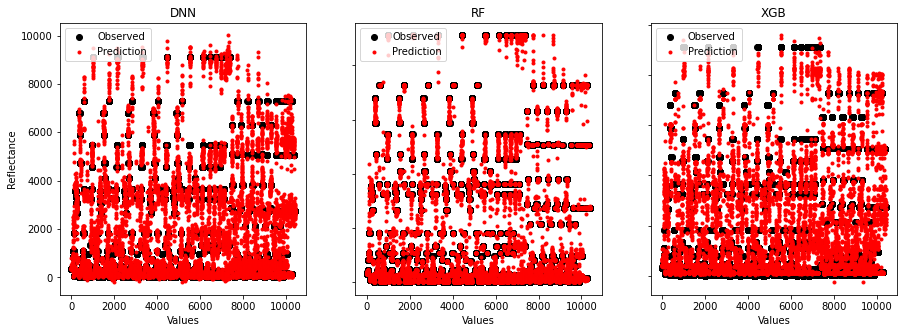

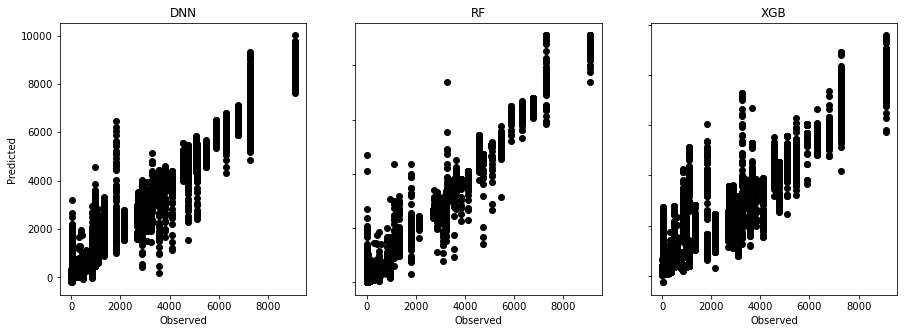

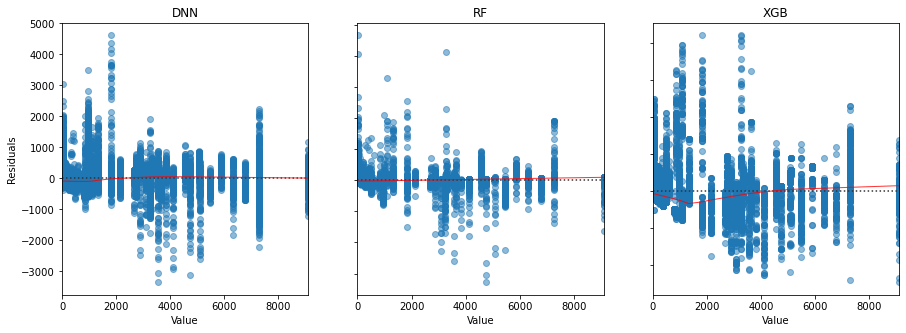

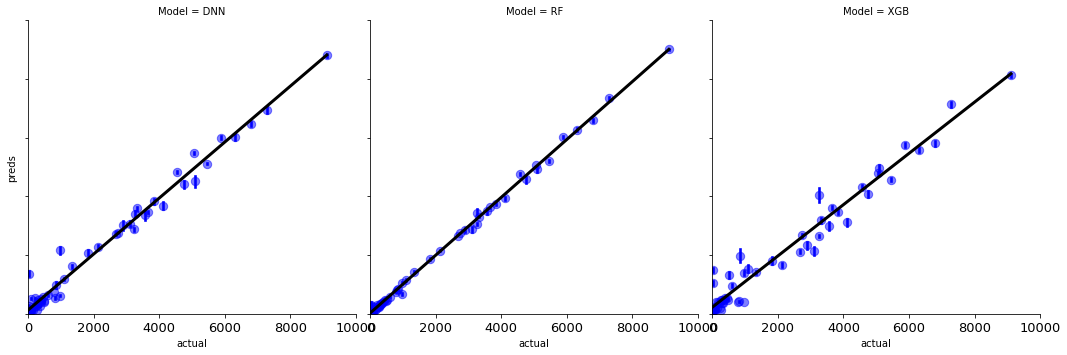

------------------------------------------------------------------------
Training for fold 4 ...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/20
1042/1042 - 6s - loss: 1849279.2500 - mean_squared_error: 1849279.2500 - val_loss: 650260.3125 - val_mean_squared_error: 650260.3125
Epoch 2/20
1042/1042 - 5s - loss: 837530.3750 - mean_squared_error: 837530.3750 - val_loss: 789521.2500 - val_mean_squared_error: 789521.2500
Epoch 3/20
1042/1042 - 5s - loss: 652464.8750 - mean_squared_error: 652464.8750 - val_loss: 462120.8438 - val_mean_squared_error: 462120.8438
Epoch 4/20
1042/1042 - 5s - loss: 574866.1875 - mean_squared_error: 574866.1875 - val_loss: 522587.1562 - val_mean_squared_error: 522587.1562
Epoch 5/20
1042/1042 - 5s - loss: 502877.0312 - mean_squared_error: 502877.0312 - val_loss: 356095.9688 - val_mean_squared_error: 356095.9688
Epoch 6/20
1042/1042 - 4s - loss: 459199.0938 - mean_squared_error: 459199.0938 - val_loss: 396392.9375 - val_mean_squared_error: 396392.9375
E

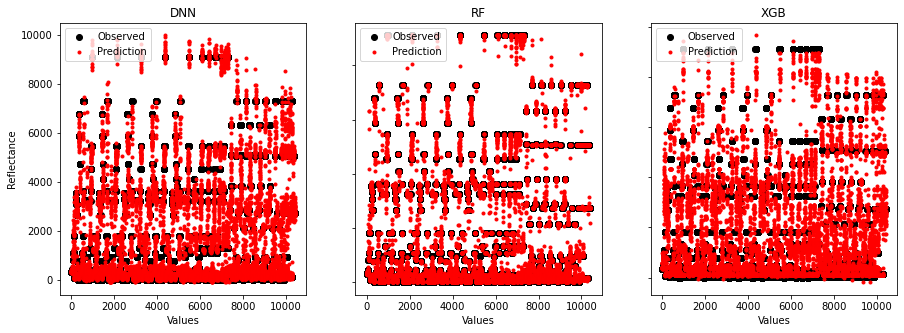

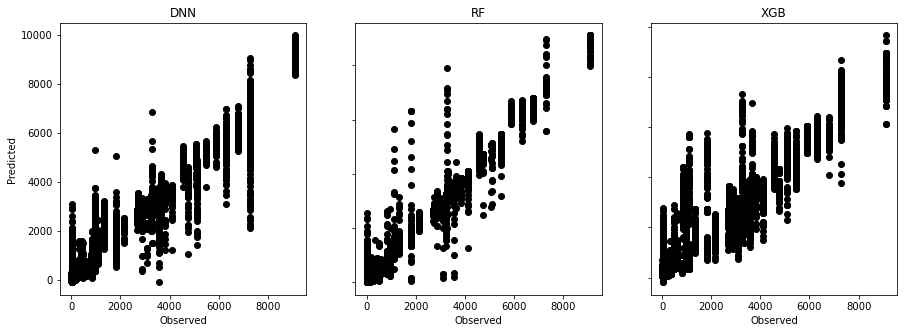

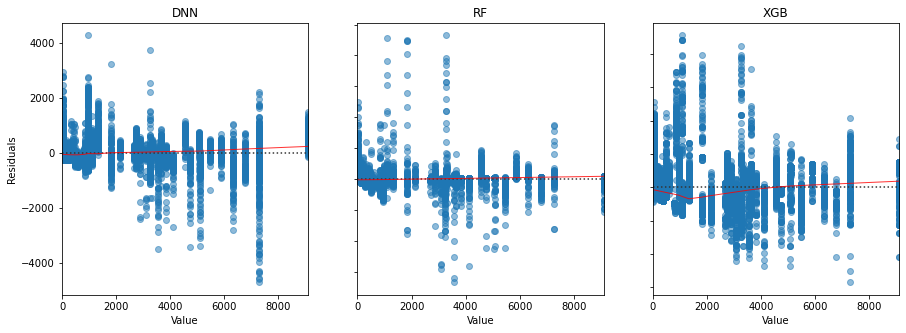

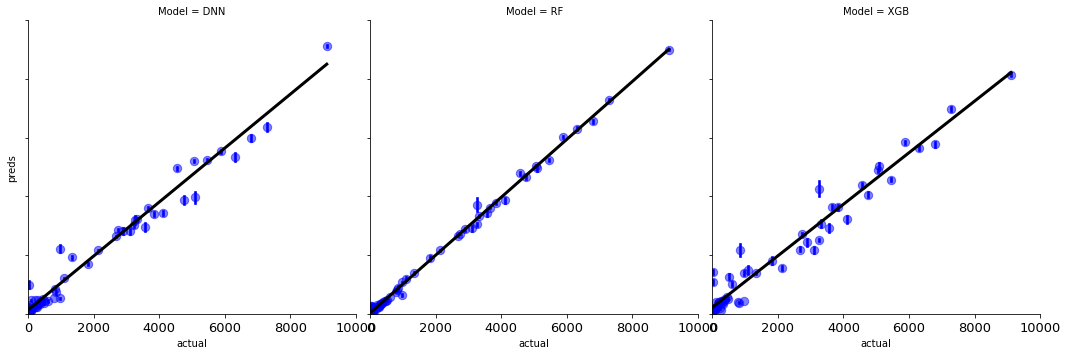

------------------------------------------------------------------------
Training for fold 5 ...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/20
1042/1042 - 5s - loss: 1861516.0000 - mean_squared_error: 1861516.0000 - val_loss: 868442.1250 - val_mean_squared_error: 868442.1250
Epoch 2/20
1042/1042 - 5s - loss: 926470.0000 - mean_squared_error: 926470.0000 - val_loss: 848348.9375 - val_mean_squared_error: 848348.9375
Epoch 3/20
1042/1042 - 4s - loss: 747393.6875 - mean_squared_error: 747393.6875 - val_loss: 597857.3125 - val_mean_squared_error: 597857.3125
Epoch 4/20
1042/1042 - 4s - loss: 630411.9375 - mean_squared_error: 630411.9375 - val_loss: 518139.2188 - val_mean_squared_error: 518139.2188
Epoch 5/20
1042/1042 - 4s - loss: 546900.2500 - mean_squared_error: 546900.2500 - val_loss: 428252.6250 - val_mean_squared_error: 428252.6250
Epoch 6/20
1042/1042 - 4s - loss: 508875.7188 - mean_squared_error: 508875.7188 - val_loss: 477728.9375 - val_mean_squared_error: 477728.9375
E

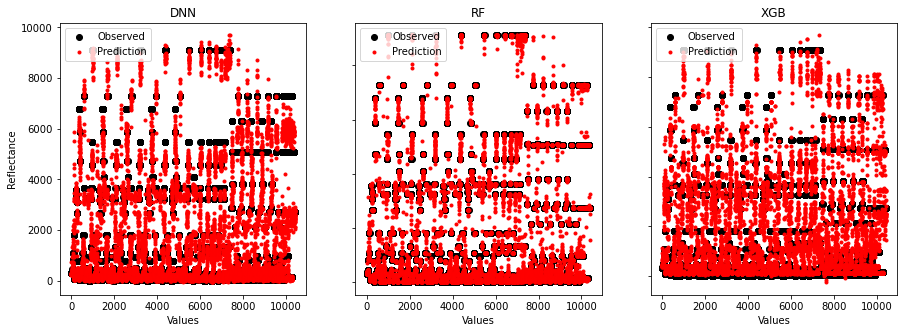

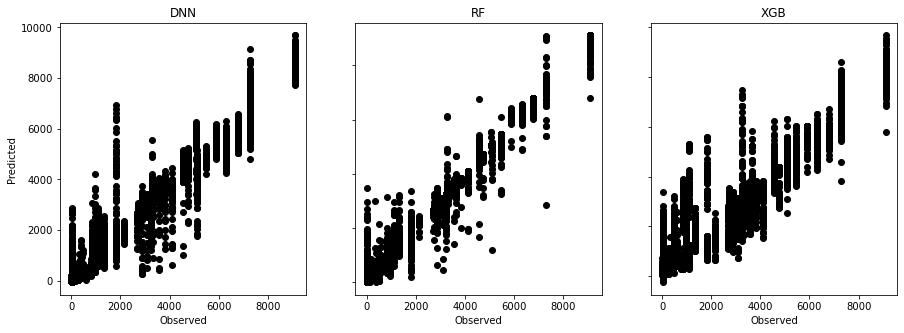

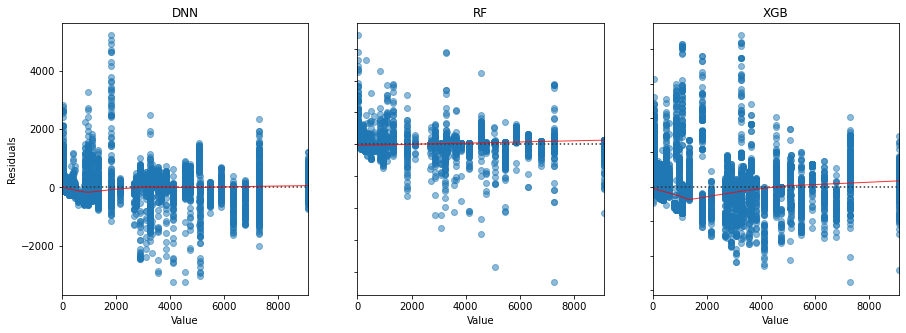

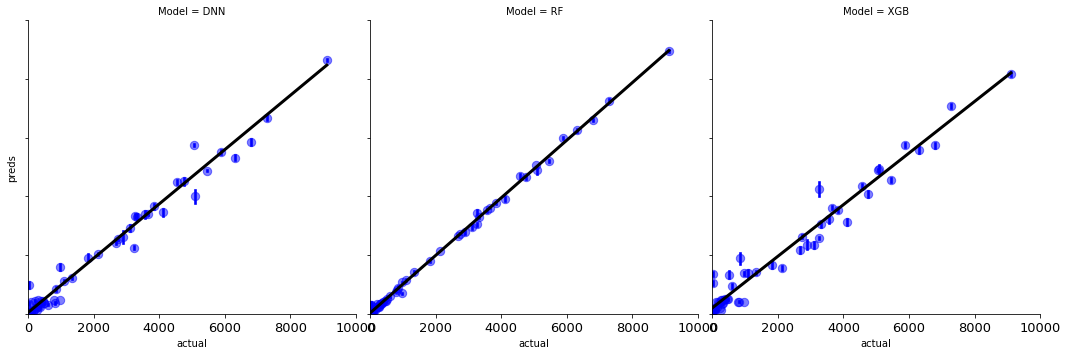

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - R2 Scores for DNN: 96.0% - RF: 99.0% - XGB: 91.0%
> Fold 1 - MAE Scores for DNN: 282.15 - RF: 78.37 - XGB: 419.38
------------------------------------------------------------------------
> Fold 2 - R2 Scores for DNN: 95.0% - RF: 99.0% - XGB: 91.0%
> Fold 2 - MAE Scores for DNN: 280.59 - RF: 81.91 - XGB: 426.14
------------------------------------------------------------------------
> Fold 3 - R2 Scores for DNN: 96.0% - RF: 99.0% - XGB: 91.0%
> Fold 3 - MAE Scores for DNN: 269.24 - RF: 82.7 - XGB: 428.62
------------------------------------------------------------------------
> Fold 4 - R2 Scores for DNN: 95.0% - RF: 99.0% - XGB: 91.0%
> Fold 4 - MAE Scores for DNN: 270.69 - RF: 80.89 - XGB: 420.28
------------------------------------------------------------------------
> Fold 5 - R2 Scores for DNN: 95.0% - RF: 99.0% 

In [9]:
# Define per-fold score containers
R2_per_fold_DNN = []
MAE_per_fold_DNN = []
R2_per_fold_RF = []
MAE_per_fold_RF = []
R2_per_fold_XGB = []
MAE_per_fold_XGB = []

W_dir = './ModelDatabase/Trained_Weights'
for f in os.listdir(W_dir):
    os.remove(os.path.join(W_dir, f))
# fix random seed for reproducibility
seed = 7
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)    
# K-fold Cross Validation model evaluation
fold_no = 1

# define standard scaler
scaler = StandardScaler()

for train, valid in kfold.split(inputs, targets):
    model = Sequential()
    #model.add(Dropout(0.2, input_shape=(5,)))
    model.add(Dense(128, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(512, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) #mean_squared_error
    model_RF = RandomForestRegressor()
    XGBModel = XGBRegressor(verbosity=0)
    #XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #   colsample_bynode=1, colsample_bytree=1, gamma=0,
    #   importance_type='gain', learning_rate=0.1, max_delta_step=0,
    #   max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
    #   n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
    #   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
    #   silent=None, subsample=1, verbosity=1)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # callbacks
    checkpoint_name = './ModelDatabase/Trained_Weights/Weights-fold'+str(fold_no)+'-ep{epoch:03d}--loss{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose =0, save_best_only = True, mode ='auto')    
    callbacks_list = [checkpoint] #tensorboard_callback
    # transform data
    train_X = scaler.fit_transform(inputs[train])
    valid_X = scaler.transform(inputs[valid])
    pickle.dump(scaler, open(W_dir+'/std_scaler_Fold_'+ str(fold_no) +'.pkl', 'wb'))
    # Fit data to model
    print(type(targets[train]))
    print(type(train_X))
    model.fit(train_X, targets[train], epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list, verbose=2)  
    model_RF.fit(train_X, targets[train])
    XGBModel.fit(train_X, targets[train], verbose=False)
    pickle.dump(model_RF, open(W_dir+'/RF_model_Fold_'+ str(fold_no) +'.sav', 'wb'))
    pickle.dump(XGBModel, open(W_dir+'/XGB_model_Fold_'+ str(fold_no) +'.sav', 'wb'))
    # Generate generalization metrics
    #scores = model.evaluate(valid_X, targets[valid], verbose=2)
    preds = model.predict(valid_X, verbose=0)
    preds_RF = model_RF.predict(valid_X)
    preds_XGB = XGBModel.predict(valid_X)
    #correlation_matrix = np.corrcoef(preds.flatten(), targets[valid])
    #correlation_xy = correlation_matrix[0,1]
    #scores = correlation_xy**2
    r2_DNN = round(r2_score(targets[valid], preds.flatten()), 2)
    mae_DNN = round(mean_absolute_error(targets[valid], preds.flatten()), 2)
    r2_RF = round(r2_score(targets[valid], preds_RF.flatten()), 2)
    mae_RF = round(mean_absolute_error(targets[valid], preds_RF.flatten()), 2)
    r2_XGB = round(r2_score(targets[valid], preds_XGB.flatten()), 2)
    mae_XGB = round(mean_absolute_error(targets[valid], preds_XGB.flatten()), 2)
    
    print(color.BOLD + color.BLUE + f'R2 Scores for fold {fold_no}: DNN of {r2_DNN*100}%; RF of {r2_RF*100}%; XGB of {r2_XGB*100}%'+ color.END)                        
    print(color.BOLD + color.BLUE + f'MAE Scores for fold {fold_no}: DNN of {mae_DNN}; RF of {mae_RF}; XGB of {mae_XGB}'+ color.END)
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].plot(np.arange(len(targets[valid])), targets[valid], 'o', color='black', label="Observed")  
    axs[0].plot(np.arange(len(preds.flatten())), preds.flatten(), '.', color='red', label="Prediction")
    axs[0].set_title('DNN')
    axs[1].plot(np.arange(len(targets[valid])), targets[valid], 'o', color='black', label="Observed")
    axs[1].plot(np.arange(len(preds_RF.flatten())), preds_RF.flatten(), '.', color='red', label="Prediction")
    axs[1].set_title('RF')
    axs[2].plot(np.arange(len(targets[valid])), targets[valid], 'o', color='black', label="Observed")
    axs[2].plot(np.arange(len(preds_XGB.flatten())), preds_XGB.flatten(), '.', color='red', label="Prediction")
    axs[2].set_title('XGB')
    
    for ax in axs.flat:
        ax.set(xlabel='Values', ylabel='Reflectance')
    for ax in axs.flat:
        ax.label_outer()
        ax.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].plot(targets[valid], preds.flatten(), 'o', color='black')  
    axs[0].set_title('DNN')
    axs[1].plot(targets[valid], preds_RF.flatten(), 'o', color='black')
    axs[1].set_title('RF')
    axs[2].plot(targets[valid], preds_XGB.flatten(), 'o', color='black')
    axs[2].set_title('XGB')
    
    for ax in axs.flat:
        ax.set(xlabel='Observed', ylabel='Predicted')
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    sb.residplot(targets[valid], preds.flatten(), 
                          ax =axs[0],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[0].set_title('DNN')
    sb.residplot(targets[valid], preds_RF.flatten(), 
                          ax =axs[1],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[1].set_title('RF')
    sb.residplot(targets[valid], preds_XGB.flatten(), 
                          ax =axs[2],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[2].set_title('XGB')
    
    for ax in axs.flat:
        ax.set(xlabel='Value', ylabel='Residuals')
    for ax in axs.flat:
        ax.label_outer()
    plt.show()
    
    #fig, axs = plt.subplots(1, 1, figsize=(15,5))
    dic = {
        'actual': targets[valid],
        'preds': preds.flatten(),
        'Model': ['DNN'] * len(targets[valid])
        }
    data1 = pd.DataFrame(dic)
    dic = {
        'actual': targets[valid],
        'preds': preds_RF.flatten(),
        'Model': ['RF'] * len(targets[valid])
        }
    data2 = pd.DataFrame(dic)
    dic = {
        'actual': targets[valid],
        'preds': preds_XGB.flatten(),
        'Model': ['XGB'] * len(targets[valid])
        }
    data3 = pd.DataFrame(dic)
    joined = pd.concat([data1, data2, data3])
    b = sb.lmplot(x="actual", y="preds", col="Model", data=joined, x_estimator=np.mean, 
                  scatter_kws={'color': 'blue', 'alpha':0.5, 's':70}, 
                  line_kws={"linewidth": 3, 'color': 'black'})  

    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    b.set_yticklabels(ylabels, size=13)
    b.set_xticklabels(xlabels, size=13)
    b.set(xlim=(0,10000),ylim=(0,10000))
    plt.show()
    
    R2_per_fold_DNN.append(r2_DNN * 100)
    MAE_per_fold_DNN.append(mae_DNN)
    R2_per_fold_RF.append(r2_RF * 100)
    MAE_per_fold_RF.append(mae_RF)
    R2_per_fold_XGB.append(r2_XGB * 100)
    MAE_per_fold_XGB.append(mae_XGB)
    
    # Increase fold number
    fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(R2_per_fold_DNN)):
    print('------------------------------------------------------------------------')
    print(color.BOLD + color.BLUE + f'> Fold {i+1} - R2 Scores for DNN: {R2_per_fold_DNN[i]}% - RF: {R2_per_fold_RF[i]}% - XGB: {R2_per_fold_XGB[i]}%' + color.END)    
    print(color.BOLD + color.BLUE + f'> Fold {i+1} - MAE Scores for DNN: {MAE_per_fold_DNN[i]} - RF: {MAE_per_fold_RF[i]} - XGB: {MAE_per_fold_XGB[i]}' + color.END)    
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(color.BOLD + color.YELLOW + f'> R2 for DNN: {round(np.mean(R2_per_fold_DNN), 2)} (+- {round(np.std(R2_per_fold_DNN), 2)}) RF: {round(np.mean(R2_per_fold_RF), 2)} (+- {round(np.std(R2_per_fold_RF), 2)}) XGB: {round(np.mean(R2_per_fold_XGB), 2)} (+- {round(np.std(R2_per_fold_XGB), 2)})' + color.END)        
print(color.BOLD + color.YELLOW + f'> R2 for DNN: {round(np.mean(MAE_per_fold_DNN), 2)} (+- {round(np.std(MAE_per_fold_DNN), 2)}) RF: {round(np.mean(MAE_per_fold_RF), 2)} (+- {round(np.std(MAE_per_fold_RF), 2)}) XGB: {round(np.mean(MAE_per_fold_XGB), 2)} (+- {round(np.std(MAE_per_fold_XGB), 2)})' + color.END)        
print('------------------------------------------------------------------------')


### Testing

wights_files Loaded!
R2 Scores : DNN of 89.0%; RF of 84.0%; XGB of 86.0%
MAE Scores : DNN of 562.66; RF of 603.32; XGB of 592.22


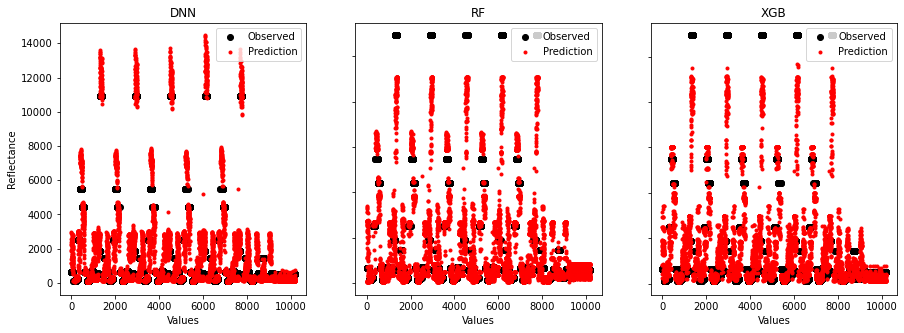

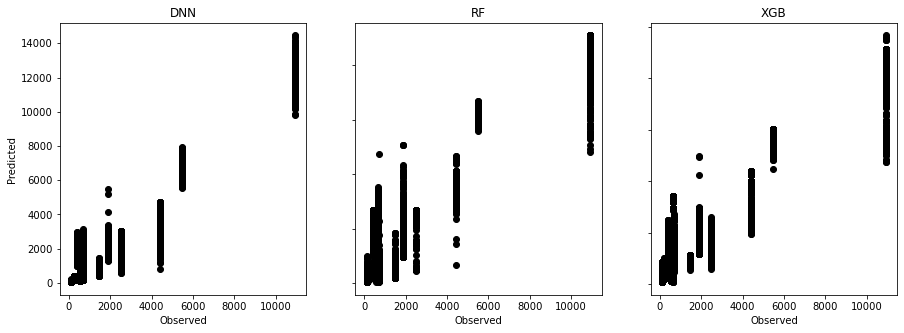

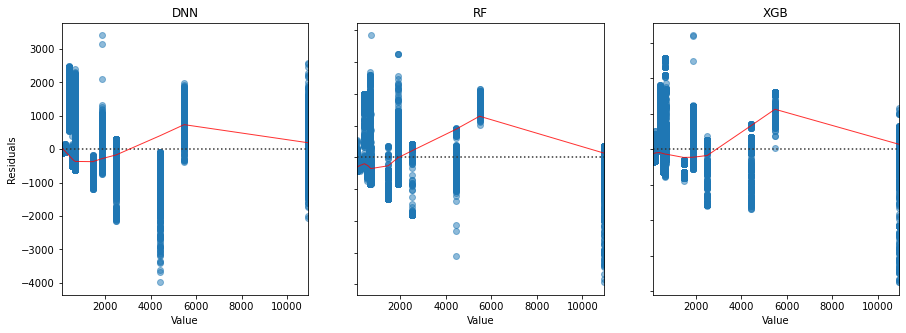

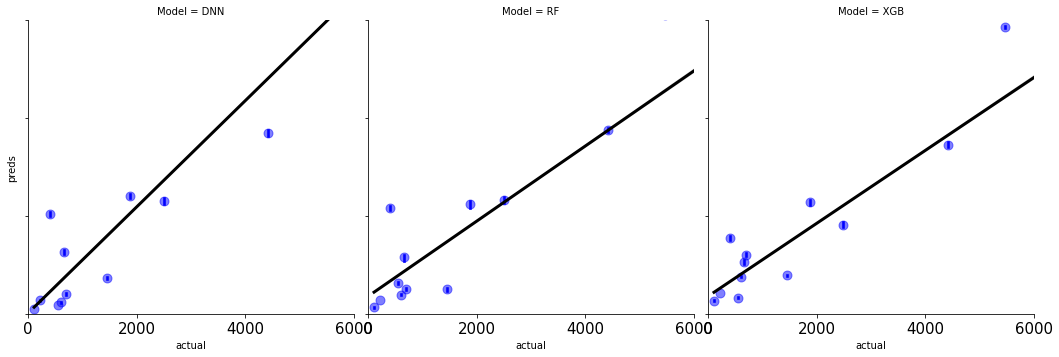

In [14]:
def Baseline_Model():
    model = Sequential()
    #model.add(Dropout(0.2, input_shape=(5,)))
    model.add(Dense(128, input_dim=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(512, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    return model

# load the model from disk
RF_filename = 'RF_model_Fold_1.sav'
XGB_filename = 'XGB_model_Fold_5.sav'
DNN_filename = 'Weights-fold3-ep008--loss321547.65625.hdf5'

RF_SC_filename = 'std_scaler_Fold_1.pkl'
XGB_SC_filename = 'std_scaler_Fold_5.pkl'
DNN_SC_filename = 'std_scaler_Fold_3.pkl'

RF_loaded_model = pickle.load(open('./ModelDatabase/Trained_Weights/' + RF_filename, 'rb'))
XGB_loaded_model = pickle.load(open('./ModelDatabase/Trained_Weights/' + XGB_filename, 'rb'))
DNN_loaded_model = Baseline_Model()
DNN_loaded_model.load_weights('./ModelDatabase/Trained_Weights/' + DNN_filename) # load it
DNN_loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
print(color.BOLD + color.BLUE +  'wights_files' + ' Loaded!' + color.END)

RF_loaded_SC_model = pickle.load(open('./ModelDatabase/Trained_Weights/' + RF_SC_filename, 'rb'))
XGB_loaded_SC_model = pickle.load(open('./ModelDatabase/Trained_Weights/' + XGB_SC_filename, 'rb'))
DNN_loaded_SC_model = pickle.load(open('./ModelDatabase/Trained_Weights/' + DNN_SC_filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
 
RF_test_X = RF_loaded_SC_model.transform(Test_Data) 
XGB_test_X = XGB_loaded_SC_model.transform(Test_Data) 
DNN_test_X = DNN_loaded_SC_model.transform(Test_Data) 

preds_DNN = DNN_loaded_model.predict(DNN_test_X, verbose=0)
preds_RF = RF_loaded_model.predict(RF_test_X)
preds_XGB = XGB_loaded_model.predict(XGB_test_X)

r2_DNN = round(r2_score(test_target, preds_DNN.flatten()), 2)
mae_DNN = round(mean_absolute_error(test_target, preds_DNN.flatten()), 2)
r2_RF = round(r2_score(test_target, preds_RF.flatten()), 2)
mae_RF = round(mean_absolute_error(test_target, preds_RF.flatten()), 2)
r2_XGB = round(r2_score(test_target, preds_XGB.flatten()), 2)
mae_XGB = round(mean_absolute_error(test_target, preds_XGB.flatten()), 2)
    
print(color.BOLD + color.BLUE + f'R2 Scores : DNN of {r2_DNN*100}%; RF of {r2_RF*100}%; XGB of {r2_XGB*100}%'+ color.END)                        
print(color.BOLD + color.BLUE + f'MAE Scores : DNN of {mae_DNN}; RF of {mae_RF}; XGB of {mae_XGB}'+ color.END)
    
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(np.arange(len(test_target)), test_target, 'o', color='black', label="Observed")  
axs[0].plot(np.arange(len(preds_DNN.flatten())), preds_DNN.flatten(), '.', color='red', label="Prediction")
axs[0].set_title('DNN')
axs[1].plot(np.arange(len(test_target)), test_target, 'o', color='black', label="Observed")
axs[1].plot(np.arange(len(preds_RF.flatten())), preds_RF.flatten(), '.', color='red', label="Prediction")
axs[1].set_title('RF')
axs[2].plot(np.arange(len(test_target)), test_target, 'o', color='black', label="Observed")
axs[2].plot(np.arange(len(preds_XGB.flatten())), preds_XGB.flatten(), '.', color='red', label="Prediction")
axs[2].set_title('XGB')
    
for ax in axs.flat:
    ax.set(xlabel='Values', ylabel='Reflectance')
for ax in axs.flat:
    ax.label_outer()
    ax.legend()
plt.show()
    
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(test_target, preds_DNN.flatten(), 'o', color='black')  
axs[0].set_title('DNN')
axs[1].plot(test_target, preds_RF.flatten(), 'o', color='black')
axs[1].set_title('RF')
axs[2].plot(test_target, preds_XGB.flatten(), 'o', color='black')
axs[2].set_title('XGB')
    
for ax in axs.flat:
    ax.set(xlabel='Observed', ylabel='Predicted')
for ax in axs.flat:
    ax.label_outer()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15,5))
sb.residplot(test_target, preds_DNN.flatten(), 
                        ax =axs[0],
                        lowess=True,
                        scatter_kws={'alpha': 0.5},
                        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axs[0].set_title('DNN')
sb.residplot(test_target, preds_RF.flatten(), 
                        ax =axs[1],
                        lowess=True,
                        scatter_kws={'alpha': 0.5},
                        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axs[1].set_title('RF')
sb.residplot(test_target, preds_XGB.flatten(), 
                        ax =axs[2],
                        lowess=True,
                        scatter_kws={'alpha': 0.5},
                        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axs[2].set_title('XGB')
    
for ax in axs.flat:
    ax.set(xlabel='Value', ylabel='Residuals')
for ax in axs.flat:
    ax.label_outer()
plt.show()
    
dic = {
    'actual': test_target,
    'preds': preds_DNN.flatten(),
    'Model': ['DNN'] * len(test_target)
    }
data1 = pd.DataFrame(dic)
dic = {
    'actual': test_target,
    'preds': preds_RF.flatten(),
    'Model': ['RF'] * len(test_target)
    }
data2 = pd.DataFrame(dic)
dic = {
    'actual': test_target,
    'preds': preds_XGB.flatten(),
    'Model': ['XGB'] * len(test_target)
    }
data3 = pd.DataFrame(dic)
joined = pd.concat([data1, data2, data3])
b = sb.lmplot(x="actual", y="preds", col="Model", data=joined, x_estimator=np.mean, 
                scatter_kws={'color': 'blue', 'alpha':0.5, 's':80}, 
                line_kws={"linewidth": 3, 'color': 'black'})  

_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
b.set_yticklabels(ylabels, size=15)
b.set_xticklabels(xlabels, size=15)
b.set(xlim=(0,6000),ylim=(0,6000))
plt.show()
    


## Feature Importance

Feature: 0, Score: 0.21293
Feature: 1, Score: 0.05138
Feature: 2, Score: 0.02047
Feature: 3, Score: 0.03984
Feature: 4, Score: 0.67538


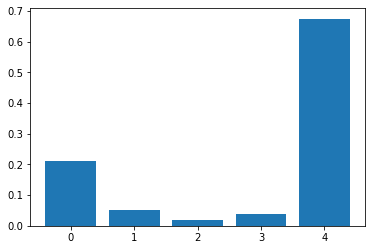

In [15]:
RF_importance = RF_loaded_model.feature_importances_
# summarize feature importance
for i,v in enumerate(RF_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(RF_importance))], RF_importance)
pyplot.show()

Feature: 0, Score: 0.16262
Feature: 1, Score: 0.05960
Feature: 2, Score: 0.09092
Feature: 3, Score: 0.05090
Feature: 4, Score: 0.63595


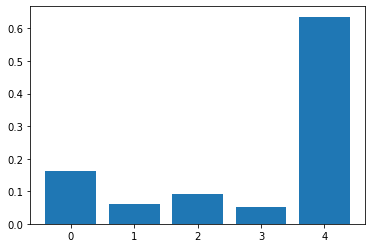

In [16]:
XGB_importance = XGB_loaded_model.feature_importances_
# summarize feature importance
for i,v in enumerate(XGB_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(XGB_importance))], XGB_importance)
pyplot.show()

Feature: 0, Score: 102787013.91305
Feature: 1, Score: 8102060.73189
Feature: 2, Score: 39095109.81870
Feature: 3, Score: 2760779.11584
Feature: 4, Score: 6195319.68174


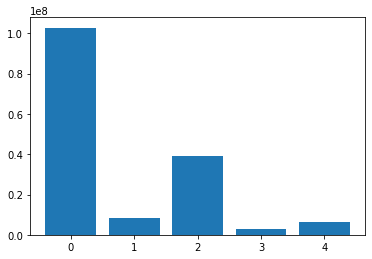

In [21]:
Tinputs = pd.concat([Train_Data, Valid_Data])
Ttargets = pd.concat([target_train, target_valid])
DNN_test_X = DNN_loaded_SC_model.transform(Tinputs) 
DNN_results = permutation_importance(DNN_loaded_model, DNN_test_X, Ttargets, scoring='neg_mean_squared_error')
# get importance
importance = DNN_results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [173]:
dic = {
    'actual': targets[valid],
    'preds': preds.flatten(),
    'Model': ['DNN'] * len(targets[valid])
    }
data1 = pd.DataFrame(dic)

dic = {
    'actual': targets[valid],
    'preds': preds_RF.flatten(),
    'Model': ['RF'] * len(targets[valid])
    }
data2 = pd.DataFrame(dic)
    
dic = {
    'actual': targets[valid],
    'preds': preds_XGB.flatten(),
    'Model': ['XGB'] * len(targets[valid])
    }
data3 = pd.DataFrame(dic)
joined = pd.concat([data1, data2, data3])
joined.tail()
#joined.size

,actual,preds,Model
10415,2732.815623,2349.599854,XGB
10416,2732.815623,2607.350342,XGB
10417,2732.815623,3444.725342,XGB
10418,2732.815623,2374.627441,XGB
10419,2732.815623,2053.971924,XGB


<Figure size 576x432 with 0 Axes>

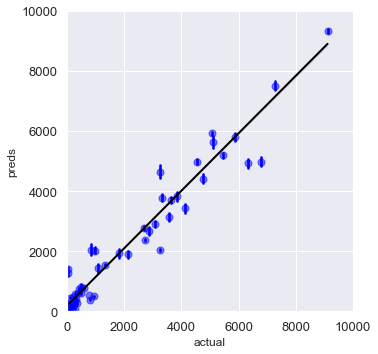

In [161]:
#fig, axs = plt.subplots(1, figsize=(15,5))
dic = {
    'actual': targets[valid],
    'preds': preds.flatten(),
    'color': ['red'] * len(targets[valid])
}
data = pd.DataFrame(dic)
#sb.set(font_scale = 1)
plt.figure(figsize=(8, 6))
b = sb.lmplot(x="actual", y="preds", data=data, x_estimator=np.mean, scatter_kws={'color': 'blue', 'alpha':0.5, 's':50}, line_kws={"linewidth": 2, 'color': 'black'})                           
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
b.set_yticklabels(ylabels, size=13)
b.set_xticklabels(xlabels, size=13)
b.set(xlim=(0,10000),ylim=(0,10000))
plt.show()
#sb.jointplot(x="actual", y="preds", data=data, kind="hist");
#sm.probplot(targets[valid], , plot=plt)
#res = targets[valid]-preds.flatten()
#QQ = ProbPlot(res)
#QQ.qqplot(line ='45')
#, hue="color", palette=dict(red="b")


<AxesSubplot:>

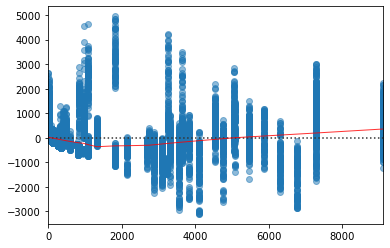

In [83]:
sb.residplot(targets[valid], preds.flatten(), 
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

In [90]:
tips = sb.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


### checkpoint callback

In [294]:
checkpoint_name = './Trained_Weights/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')    
callbacks_list = [checkpoint]

### Train

In [295]:
NN_model.fit(Train_Data, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)  

Epoch 1/500
1/5 [=====>........................] - ETA: 0s - loss: 92.4825 - mean_absolute_error: 92.4825
Epoch 00001: val_loss improved from inf to 3.03186, saving model to ./Trained_Weights\Weights-001--3.03186.hdf5
5/5 [==============================] - 0s 58ms/step - loss: 104.4673 - mean_absolute_error: 104.4673 - val_loss: 3.0319 - val_mean_absolute_error: 3.0319
Epoch 2/500
1/5 [=====>........................] - ETA: 0s - loss: 103.9994 - mean_absolute_error: 103.9994
Epoch 00002: val_loss improved from 3.03186 to 1.35732, saving model to ./Trained_Weights\Weights-002--1.35732.hdf5
5/5 [==============================] - 0s 16ms/step - loss: 95.4888 - mean_absolute_error: 95.4888 - val_loss: 1.3573 - val_mean_absolute_error: 1.3573
Epoch 3/500
1/5 [=====>........................] - ETA: 0s - loss: 99.5999 - mean_absolute_error: 99.5999
Epoch 00003: val_loss did not improve from 1.35732
5/5 [==============================] - 0s 10ms/step - loss: 98.6277 - mean_absolute_error: 98.6

Epoch 53/500
1/5 [=====>........................] - ETA: 0s - loss: 57.1535 - mean_absolute_error: 57.1535
Epoch 00053: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 68.8677 - mean_absolute_error: 68.8677 - val_loss: 5.6146 - val_mean_absolute_error: 5.6146
Epoch 54/500
1/5 [=====>........................] - ETA: 0s - loss: 83.3569 - mean_absolute_error: 83.3569
Epoch 00054: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 69.8622 - mean_absolute_error: 69.8622 - val_loss: 6.0051 - val_mean_absolute_error: 6.0051
Epoch 55/500
1/5 [=====>........................] - ETA: 0s - loss: 41.9658 - mean_absolute_error: 41.9658
Epoch 00055: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 67.8407 - mean_absolute_error: 67.8407 - val_loss: 3.1437 - val_mean_absolute_error: 3.1437
Epoch 56/500
1/5 [=====>........................] - ETA: 0s - loss: 46.85

Epoch 80/500
1/5 [=====>........................] - ETA: 0s - loss: 72.0253 - mean_absolute_error: 72.0253
Epoch 00080: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 12ms/step - loss: 53.3317 - mean_absolute_error: 53.3317 - val_loss: 3.0683 - val_mean_absolute_error: 3.0683
Epoch 81/500
1/5 [=====>........................] - ETA: 0s - loss: 65.9202 - mean_absolute_error: 65.9202
Epoch 00081: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 13ms/step - loss: 51.1140 - mean_absolute_error: 51.1140 - val_loss: 0.8019 - val_mean_absolute_error: 0.8019
Epoch 82/500
1/5 [=====>........................] - ETA: 0s - loss: 40.5013 - mean_absolute_error: 40.5013
Epoch 00082: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 11ms/step - loss: 46.8132 - mean_absolute_error: 46.8132 - val_loss: 2.3214 - val_mean_absolute_error: 2.3214
Epoch 83/500
1/5 [=====>........................] - ETA: 0s - loss: 48

Epoch 133/500
1/5 [=====>........................] - ETA: 0s - loss: 8.0772 - mean_absolute_error: 8.0772
Epoch 00133: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 8.9487 - mean_absolute_error: 8.9487 - val_loss: 0.9572 - val_mean_absolute_error: 0.9572
Epoch 134/500
1/5 [=====>........................] - ETA: 0s - loss: 8.1288 - mean_absolute_error: 8.1288
Epoch 00134: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 11ms/step - loss: 17.2246 - mean_absolute_error: 17.2246 - val_loss: 4.7031 - val_mean_absolute_error: 4.7031
Epoch 135/500
1/5 [=====>........................] - ETA: 0s - loss: 6.0700 - mean_absolute_error: 6.0700
Epoch 00135: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 14ms/step - loss: 13.9129 - mean_absolute_error: 13.9129 - val_loss: 3.3721 - val_mean_absolute_error: 3.3721
Epoch 136/500
1/5 [=====>........................] - ETA: 0s - loss: 9.7228 

Epoch 160/500
1/5 [=====>........................] - ETA: 0s - loss: 19.1848 - mean_absolute_error: 19.1848
Epoch 00160: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 17.4227 - mean_absolute_error: 17.4227 - val_loss: 6.1077 - val_mean_absolute_error: 6.1077
Epoch 161/500
1/5 [=====>........................] - ETA: 0s - loss: 30.2963 - mean_absolute_error: 30.2963
Epoch 00161: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 28.1630 - mean_absolute_error: 28.1630 - val_loss: 0.9450 - val_mean_absolute_error: 0.9450
Epoch 162/500
1/5 [=====>........................] - ETA: 0s - loss: 11.0087 - mean_absolute_error: 11.0087
Epoch 00162: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 24.7919 - mean_absolute_error: 24.7919 - val_loss: 10.1881 - val_mean_absolute_error: 10.1881
Epoch 163/500
1/5 [=====>........................] - ETA: 0s - loss:

Epoch 187/500
1/5 [=====>........................] - ETA: 0s - loss: 8.0568 - mean_absolute_error: 8.0568
Epoch 00187: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 12ms/step - loss: 12.2187 - mean_absolute_error: 12.2187 - val_loss: 0.8009 - val_mean_absolute_error: 0.8009
Epoch 188/500
1/5 [=====>........................] - ETA: 0s - loss: 13.7921 - mean_absolute_error: 13.7921
Epoch 00188: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 15ms/step - loss: 14.5980 - mean_absolute_error: 14.5980 - val_loss: 6.2377 - val_mean_absolute_error: 6.2377
Epoch 189/500
1/5 [=====>........................] - ETA: 0s - loss: 30.6788 - mean_absolute_error: 30.6788
Epoch 00189: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 10ms/step - loss: 19.3022 - mean_absolute_error: 19.3022 - val_loss: 0.8674 - val_mean_absolute_error: 0.8674
Epoch 190/500
1/5 [=====>........................] - ETA: 0s - loss: 

Epoch 214/500
1/5 [=====>........................] - ETA: 0s - loss: 30.1032 - mean_absolute_error: 30.1032
Epoch 00214: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 10ms/step - loss: 24.2547 - mean_absolute_error: 24.2547 - val_loss: 2.0416 - val_mean_absolute_error: 2.0416
Epoch 215/500
1/5 [=====>........................] - ETA: 0s - loss: 19.5923 - mean_absolute_error: 19.5923
Epoch 00215: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 10ms/step - loss: 11.7298 - mean_absolute_error: 11.7298 - val_loss: 0.6826 - val_mean_absolute_error: 0.6826
Epoch 216/500
1/5 [=====>........................] - ETA: 0s - loss: 10.0623 - mean_absolute_error: 10.0623
Epoch 00216: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 12.7136 - mean_absolute_error: 12.7136 - val_loss: 2.1559 - val_mean_absolute_error: 2.1559
Epoch 217/500
1/5 [=====>........................] - ETA: 0s - loss:

Epoch 267/500
1/5 [=====>........................] - ETA: 0s - loss: 2.5418 - mean_absolute_error: 2.5418
Epoch 00267: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 11ms/step - loss: 4.1191 - mean_absolute_error: 4.1191 - val_loss: 0.7672 - val_mean_absolute_error: 0.7672
Epoch 268/500
1/5 [=====>........................] - ETA: 0s - loss: 9.3064 - mean_absolute_error: 9.3064
Epoch 00268: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 15ms/step - loss: 7.7880 - mean_absolute_error: 7.7880 - val_loss: 4.1750 - val_mean_absolute_error: 4.1750
Epoch 269/500
1/5 [=====>........................] - ETA: 0s - loss: 17.6174 - mean_absolute_error: 17.6174
Epoch 00269: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 14ms/step - loss: 18.5072 - mean_absolute_error: 18.5072 - val_loss: 2.3459 - val_mean_absolute_error: 2.3459
Epoch 270/500
1/5 [=====>........................] - ETA: 0s - loss: 26.936

Epoch 294/500
1/5 [=====>........................] - ETA: 0s - loss: 12.3904 - mean_absolute_error: 12.3904
Epoch 00294: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 8.9268 - mean_absolute_error: 8.9268 - val_loss: 2.7895 - val_mean_absolute_error: 2.7895
Epoch 295/500
1/5 [=====>........................] - ETA: 0s - loss: 15.9349 - mean_absolute_error: 15.9349
Epoch 00295: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 16.4928 - mean_absolute_error: 16.4928 - val_loss: 1.3924 - val_mean_absolute_error: 1.3924
Epoch 296/500
1/5 [=====>........................] - ETA: 0s - loss: 9.1904 - mean_absolute_error: 9.1904
Epoch 00296: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 11.4533 - mean_absolute_error: 11.4533 - val_loss: 0.8894 - val_mean_absolute_error: 0.8894
Epoch 297/500
1/5 [=====>........................] - ETA: 0s - loss: 10.54

Epoch 321/500
1/5 [=====>........................] - ETA: 0s - loss: 10.1908 - mean_absolute_error: 10.1908
Epoch 00321: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 13.7518 - mean_absolute_error: 13.7518 - val_loss: 2.7940 - val_mean_absolute_error: 2.7940
Epoch 322/500
1/5 [=====>........................] - ETA: 0s - loss: 10.8044 - mean_absolute_error: 10.8044
Epoch 00322: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 14.8619 - mean_absolute_error: 14.8619 - val_loss: 1.0113 - val_mean_absolute_error: 1.0113
Epoch 323/500
1/5 [=====>........................] - ETA: 0s - loss: 2.4572 - mean_absolute_error: 2.4572
Epoch 00323: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 11.4536 - mean_absolute_error: 11.4536 - val_loss: 0.5357 - val_mean_absolute_error: 0.5357
Epoch 324/500
1/5 [=====>........................] - ETA: 0s - loss: 23.

Epoch 348/500
1/5 [=====>........................] - ETA: 0s - loss: 19.9404 - mean_absolute_error: 19.9404
Epoch 00348: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 17.8403 - mean_absolute_error: 17.8403 - val_loss: 5.1235 - val_mean_absolute_error: 5.1235
Epoch 349/500
1/5 [=====>........................] - ETA: 0s - loss: 13.6240 - mean_absolute_error: 13.6240
Epoch 00349: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 12.1597 - mean_absolute_error: 12.1597 - val_loss: 0.7471 - val_mean_absolute_error: 0.7471
Epoch 350/500
1/5 [=====>........................] - ETA: 0s - loss: 25.2520 - mean_absolute_error: 25.2520
Epoch 00350: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 12.3479 - mean_absolute_error: 12.3479 - val_loss: 4.5519 - val_mean_absolute_error: 4.5519
Epoch 351/500
1/5 [=====>........................] - ETA: 0s - loss: 1

Epoch 375/500
1/5 [=====>........................] - ETA: 0s - loss: 3.0944 - mean_absolute_error: 3.0944
Epoch 00375: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 8.8931 - mean_absolute_error: 8.8931 - val_loss: 0.5972 - val_mean_absolute_error: 0.5972
Epoch 376/500
1/5 [=====>........................] - ETA: 0s - loss: 2.7100 - mean_absolute_error: 2.7100
Epoch 00376: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 12.8858 - mean_absolute_error: 12.8858 - val_loss: 2.9984 - val_mean_absolute_error: 2.9984
Epoch 377/500
1/5 [=====>........................] - ETA: 0s - loss: 25.5227 - mean_absolute_error: 25.5227
Epoch 00377: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 13.0578 - mean_absolute_error: 13.0578 - val_loss: 3.7689 - val_mean_absolute_error: 3.7689
Epoch 378/500
1/5 [=====>........................] - ETA: 0s - loss: 9.5847 

Epoch 402/500
1/5 [=====>........................] - ETA: 0s - loss: 5.2173 - mean_absolute_error: 5.2173
Epoch 00402: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 11.5513 - mean_absolute_error: 11.5513 - val_loss: 3.3217 - val_mean_absolute_error: 3.3217
Epoch 403/500
1/5 [=====>........................] - ETA: 0s - loss: 26.6760 - mean_absolute_error: 26.6760
Epoch 00403: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 16.8219 - mean_absolute_error: 16.8219 - val_loss: 2.1427 - val_mean_absolute_error: 2.1427
Epoch 404/500
1/5 [=====>........................] - ETA: 0s - loss: 4.1686 - mean_absolute_error: 4.1686
Epoch 00404: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 13.2510 - mean_absolute_error: 13.2510 - val_loss: 3.8307 - val_mean_absolute_error: 3.8307
Epoch 405/500
1/5 [=====>........................] - ETA: 0s - loss: 18.97

Epoch 429/500
1/5 [=====>........................] - ETA: 0s - loss: 5.9739 - mean_absolute_error: 5.9739
Epoch 00429: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 7.0478 - mean_absolute_error: 7.0478 - val_loss: 0.5385 - val_mean_absolute_error: 0.5385
Epoch 430/500
1/5 [=====>........................] - ETA: 0s - loss: 2.8753 - mean_absolute_error: 2.8753
Epoch 00430: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 5.8398 - mean_absolute_error: 5.8398 - val_loss: 0.5049 - val_mean_absolute_error: 0.5049
Epoch 431/500
1/5 [=====>........................] - ETA: 0s - loss: 5.4452 - mean_absolute_error: 5.4452
Epoch 00431: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 4.0675 - mean_absolute_error: 4.0675 - val_loss: 0.7033 - val_mean_absolute_error: 0.7033
Epoch 432/500
1/5 [=====>........................] - ETA: 0s - loss: 5.9508 - mean

Epoch 456/500
1/5 [=====>........................] - ETA: 0s - loss: 6.9331 - mean_absolute_error: 6.9331
Epoch 00456: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 12ms/step - loss: 6.4812 - mean_absolute_error: 6.4812 - val_loss: 2.0019 - val_mean_absolute_error: 2.0019
Epoch 457/500
1/5 [=====>........................] - ETA: 0s - loss: 7.9017 - mean_absolute_error: 7.9017
Epoch 00457: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 12ms/step - loss: 11.3393 - mean_absolute_error: 11.3393 - val_loss: 1.2848 - val_mean_absolute_error: 1.2848
Epoch 458/500
1/5 [=====>........................] - ETA: 0s - loss: 27.4837 - mean_absolute_error: 27.4837
Epoch 00458: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 9ms/step - loss: 21.6166 - mean_absolute_error: 21.6166 - val_loss: 2.3142 - val_mean_absolute_error: 2.3142
Epoch 459/500
1/5 [=====>........................] - ETA: 0s - loss: 31.00

Epoch 483/500
1/5 [=====>........................] - ETA: 0s - loss: 4.6580 - mean_absolute_error: 4.6580
Epoch 00483: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 5.3153 - mean_absolute_error: 5.3153 - val_loss: 1.4030 - val_mean_absolute_error: 1.4030
Epoch 484/500
1/5 [=====>........................] - ETA: 0s - loss: 3.8583 - mean_absolute_error: 3.8583
Epoch 00484: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 12.0734 - mean_absolute_error: 12.0734 - val_loss: 4.0198 - val_mean_absolute_error: 4.0198
Epoch 485/500
1/5 [=====>........................] - ETA: 0s - loss: 16.3584 - mean_absolute_error: 16.3584
Epoch 00485: val_loss did not improve from 0.31682
5/5 [==============================] - 0s 8ms/step - loss: 12.4377 - mean_absolute_error: 12.4377 - val_loss: 1.3910 - val_mean_absolute_error: 1.3910
Epoch 486/500
1/5 [=====>........................] - ETA: 0s - loss: 11.8128

#### >>>>>>>>>>>>>> For pretrained models <<<<<<<<<<<<<<<<<<

In [323]:
# Load wights file of the best model :
wights_file = './Trained_Weights/Weights-024--0.31682.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print(color.BOLD + color.BLUE +  wights_file[18:] + ' Loaded!' + color.END)

Weights-024--0.31682.hdf5 Loaded!


### Predict

No handles with labels found to put in legend.


 r2_score: 0.0
 MAE: 1293.5724951932254


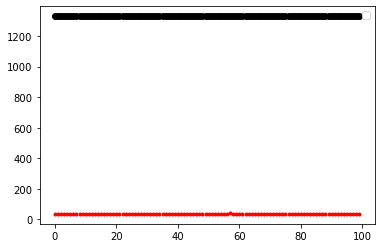

In [335]:
predictions = NN_model.predict(Test_Data)
r2 = r2_score(test_target, predictions)
mae = mean_absolute_error(test_target, predictions)

print(color.BOLD + color.BLUE + ' r2_score: ' + str(r2) + color.END)
print(color.BOLD + color.BLUE + ' MAE: ' +  str(mae) + color.END)

plt.plot(np.arange(len(test_target)), test_target, 'o', color='black');
plt.plot(np.arange(len(predictions)), predictions, '.', color='red');

## Random Forest

In [336]:
model = RandomForestRegressor()
model.fit(Train_Data, target)

# Get the mean absolute error on the validation data
predictions = model.predict(Test_Data)
r2 = r2_score(test_target, predictions)
mae = mean_absolute_error(test_target, predictions)

print(color.BOLD + color.BLUE + ' r2_score: ' + str(r2) + color.END)
print(color.BOLD + color.BLUE + ' MAE: ' +  str(mae) + color.END)

 r2_score: 0.0
 MAE: 1284.8060702465473


## XGBoost

In [337]:
XGBModel = XGBRegressor()
XGBModel.fit(Train_Data, target, verbose=True)

# Get the mean absolute error on the validation data :
predictions = XGBModel.predict(Train_Data)
r2 = r2_score(test_target, predictions)
mae = mean_absolute_error(test_target, predictions)

print(color.BOLD + color.BLUE + ' r2_score: ' + str(r2) + color.END)
print(color.BOLD + color.BLUE + ' MAE: ' +  str(mae) + color.END)

[16:29:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 r2_score: 0.0
 MAE: 1293.5337844083133


In [277]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

num_cols = get_cols_with_no_nans(Train_Data , 'num')
cat_cols = get_cols_with_no_nans(Train_Data , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(Train_Data.shape[1]))
combined = oneHotEncode(Train_Data, cat_cols)
print('There are {} columns after encoding categorical features'.format(Train_Data.shape[1]))
combined.head()


def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
  train, test = split_combined()

Number of numerical columns with no nan values : 5
Number of nun-numerical columns with no nan values : 0


There were 5 columns before encoding categorical features
There are 5 columns after encoding categorical features


,Blue,Green,Red,Redge,Nir
0,0.111548,0.143742,0.149961,0.117494,0.058115
1,0.119764,0.152795,0.158470,0.122849,0.061556
2,0.128532,0.161572,0.165700,0.128477,0.065008
3,0.135944,0.169864,0.173386,0.134157,0.067988
4,0.141400,0.178410,0.180494,0.138116,0.069776


Image Dimentions
2


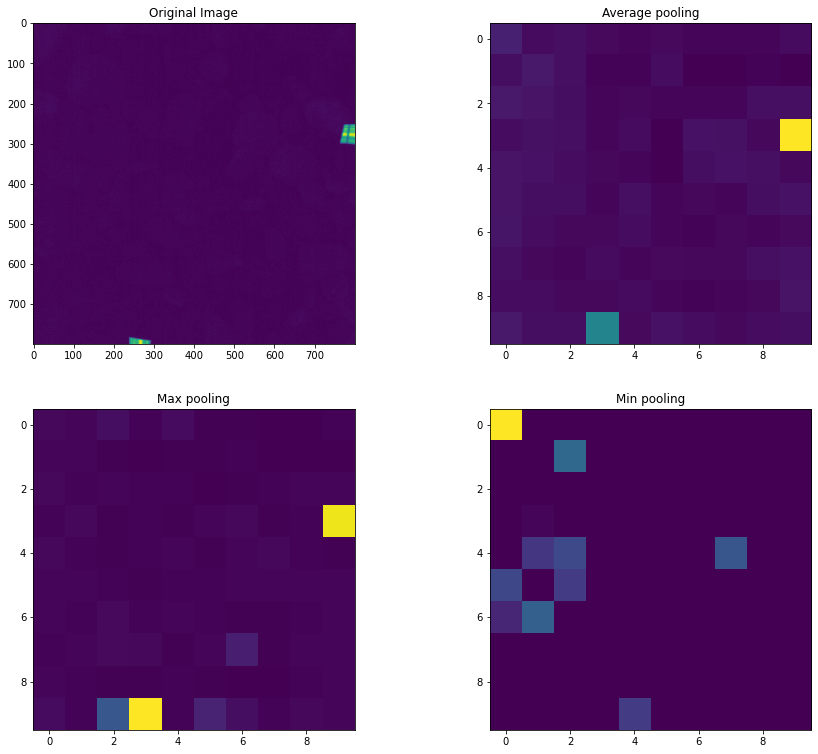

In [31]:
imageRaw=np.load(imagePath1) #plt.imread(imagePath1)
img = imageRaw
print('Image Dimentions')
print(imageRaw.ndim)
mean_pool=block_reduce(img, block_size=(80,80), func=np.mean)
max_pool=block_reduce(img, block_size=(80,80), func=np.max)
min_pool=block_reduce(img, block_size=(80,80), func=np.min)

plt.figure(figsize=(15, 13))
plt.subplot(221)
imgplot = plt.imshow(img)
plt.title('Original Image')

plt.subplot(222)
imgplot3 = plt.imshow(mean_pool)
plt.title('Average pooling')

plt.subplot(223)
imgplot1 = plt.imshow(max_pool)
plt.title('Max pooling')

plt.subplot(224)
imgplot1 = plt.imshow(min_pool)
plt.title('Min pooling')

plt.show()

In [37]:
Ave_SSC = mean_pool.flatten()
Len_SSC = len(Ave_SSC)
with open(imagePath2) as json_file:
    MetaData = json.load(json_file)
Obs_SSC = MetaData['SSC_Value']
Labels = np.repeat(Obs_SSC, Len_SSC)

In [51]:
df = pd.DataFrame([1, 2, 3, 4])
Con_Level = df[df.columns[0]]
type(Con_Level)

pandas.core.series.Series

In [51]:
Train_Data.shape

(36700, 5)

In [22]:
os.listdir(W_dir)

[]

In [73]:
tensorboard --logdir log

Reusing TensorBoard on port 6006 (pid 11480), started 0:25:09 ago. (Use '!kill 11480' to kill it.)

In [89]:
str(2)

'2'